<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# 1. Model building

## 1.1 Prognostic validation (Discriminative and calibrative)

### 1.1.1 Discriminative
#### Harrell's / Uno's Concordance
##### Fig. 1 At 5 years, Model selection of (all features - CPH, RSF, NCOX) along with ranking across folds
##### Fig. 2 At 5 years, (ISS, R-ISS, R2-ISS, NCOX with top gens) along with ranking across folds
##### Fig. 3 At 1:5 years, (ISS, R-ISS, R2-ISS, NCOX with top gens)

### 1.1.2 Calibrative
#### Integrated Brier Score (IBS)
##### Fig. 7 At 5 years, (ISS, R-ISS, R2-ISS, NCOX with top gens) along with ranking across folds

#### Negative Binomial log-likelihood (NBLL)
##### Fig. 8 At 5 years, (ISS, R-ISS, R2-ISS, NCOX with top gens) along with ranking across folds

## 1.2 Feature selection to choose top gens (our hybrid approach)
### Fig. 9 (5 states all features ranked)
### Fig. 10 aggregate feature importance
### Fig. 11 (heatmap + lineplot ) Hybrid approach

## 1.3 Impact of Feature group addition on Harrell's C (does order matter to impact of feature group to concordance)
### Fig. 12 order along with ranking across folds
#### Fig. 13 relative increase (%) of c-index normalized for the number of features of the group
### Fig. 14 reverse order along with ranking across folds
#### Fig. 15 relative increase (%) of c-index normalized for the number of features of the group

# 2. LOOCV
## Fig. 17 Risk barplot at 5 years by timepoint (P1/P2)
## Fig. 18 Risk Density by SCT
### Fig. 19 Risk Density by our model chosen features by SCT

# 3. Model validation on external test set
## Fig. 16 Harrell's C At 5 years, (ISS, NCOX with top gens)

# 4. Risk comparisons between CV and HD6 set
## Fig. 20 Risk overlap between CV and LOOCV
## Fig. 21 Risk overlap between CV and HD6
## Fig. 22 Restratify ISS by IRMM (on CV and HD6)

# 5. Treatment variance
## Fig. 23 Treatment variance plots on CV (by SCT, maint, neither, both)
## Fig. 24 TSNE (2/3D)

# 6. Individualized risks (CV/HD6)
## Fig. 25 scatter plot of least to high risk (by SCT)
## Fig. 26 loocv (or mean for HD6) sediment plots of individual patients ranked by risk of remission/pfs
## Fig. 27 For HD6, boxplots with 6 states for each patient

In [2]:
# Load libraries
import pandas as pd; import seaborn as sns; import matplotlib.pyplot as plt; import numpy as np; 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator); from IPython.display import Markdown;
from fractions import Fraction; import glob as glob; import scipy ; import itertools as it;
import warnings; import functools as ft; import matplotlib.pylab as pylab ; import matplotlib as mpl;
from scipy.stats import wilcoxon; import scipy; from IPython.display import Image
from sklearn.neighbors import KDTree
from sklearn.impute import KNNImputer
import sklearn.preprocessing as preprocess

warnings.filterwarnings('ignore')

# cd to base directory in which you see all the folders such as /code /data_in /data_out
base_dir = '/home/axr2376/pred_1_0_paper'

# Git clone from our repository 
# This jupyter notebook is present in /code

In [3]:
## OS
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('brown','1. Model building'))

</font><h1><strong><font color=brown>1. Model building</strong></h1>

In [4]:
## OS
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#f67b51','1.1 Prognostic validation'))

</font><h1><strong><font color=#f67b51>1.1 Prognostic validation</strong></h1>

In [5]:
# CV on 1933 samples
# Groups: ISS, R-ISS, R2-ISS, CPH on all features, RSF on all features, IRMM
# group = '0~1~2~9~100'
group = '0~1~2~3~4~5~6~7~8~9~10~11~12~13~14~15~16~17~18~19~20~21~22~100'

# os
os_cv = 'os_ext_val_False' 
os_hd = 'os_ext_val_True'

# efs
efs_cv = 'efs_ext_val_False' 
efs_hd = 'efs_ext_val_True'

targ_dir = base_dir + "/data_out/expt_1/plots/"

time_risk_days = 1825

In [6]:
rename_x_id = {
                    'M-CPH-R (Group=100)': 'M-CPH-R', 'M-RSF (Group=100)': 'M-RSF',
                    'M-Neural CNPH (Group=100)': 'IRMMa',
                    'M-CPH-R (Group=0)': 'R-ISS', 'M-CPH-R (Group=1)': 'R2-ISS',
                    'M-CPH-R (Group=2)': 'ISS',
                    'M-Neural CNPH (Group=3)': '+Clinical',
                    'M-Neural CNPH (Group=4)': '+Transloc',
                    'M-Neural CNPH (Group=5)': '+SCT',
                    'M-Neural CNPH (Group=6)': '+Cont. treat',
                    'M-Neural CNPH (Group=7)': '+Therapy',
                    'M-Neural CNPH (Group=9)': 'IRMMa (with TG)',
                    'M-CPH-R (Group=10)': 'GEP70',
                    'M-Neural CNPH (Group=11)': 'ISS+SCT',
                    'M-Neural CNPH (Group=12)': 'ISS+Cont. treat',
                    'M-Neural CNPH (Group=13)': 'ISS+Rec. Transloc',
                    'M-Neural CNPH (Group=14)': 'ISS+Therapy',
                    'M-Neural CNPH (Group=15)': 'ISS+TopGen',
                    'M-Neural CNPH (Group=16)': 'Top Genomics',
                    'M-Neural CNPH (Group=17)': '(R_)+Therapy',
                    'M-Neural CNPH (Group=18)': '(R_)+Cont. treat',
                    'M-Neural CNPH (Group=19)': '(R_)+SCT',
                    'M-Neural CNPH (Group=20)': '(R_)+Transloc',
                    'M-Neural CNPH (Group=21)': '(R_)+Clinical',
                    'M-Neural CNPH (Group=22)': '(R_)+ISS',
                   }


rename_x_id_df = pd.DataFrame.from_dict(rename_x_id, orient='index').reset_index().rename(columns={'index': 'old', 0: 'ID'})

In [7]:
## Run python code to get files needed to run this section of code
def metric_rank_at_xyrs(sel_models, outcome_typ, __dir__, file_, metric_):
    '''
    sel_models (list of str) is to be ordered according to your expected output
    outcome_typ (str) is either os_cv, efs_cv, os_hd, efs_hd
    base_dir (str)
    file_ (str): all groups 
    metric_ (str): C_index_harrell, C_index_uno, brier score, nbll
    '''

    df_xyr = pd.read_csv(__dir__ + outcome_typ + "_" + str(time_risk_days) + "_group_" + file_ + ".csv")[[metric_, 'X_ID', 'Fold']]
    df_ = pd.merge(df_xyr, rename_x_id_df, left_on='X_ID', right_on='old')[['ID', metric_, 'Fold']]
    df_ = df_.dropna(subset=[metric_])
    df_ = df_[df_['ID'].isin(sel_models)]
    
    # rank models across folds
    df_sub_copy = df_.copy()
    df_sub = pd.pivot(df_, index='Fold', columns='ID', values=metric_)
    list_of_models = df_sub_copy.groupby(['ID'])[metric_].median().to_frame().reset_index().set_index('ID').reindex(sel_models).index.to_list()
    df_sub_c_ind_vals = df_sub.copy()

    if metric_ == 'Int_Brier_Score' or metric_ == 'NBLL':
        df_sub = df_sub
    elif metric_ == 'C_index_harrell' or metric_ == 'C_index_uno':
        df_sub = 1 - df_sub
    df_sub_rank = df_sub.T.rank(method='min')

    df_sub_rank = pd.DataFrame(df_sub_rank.T.value_counts().rename('count')).reset_index()

    concat_df = pd.DataFrame() # percentage ranked order
    for item in list_of_models:
        df_model = df_sub_rank[[item, 'count']]
        df_model = df_model.groupby([item]).agg({'count': 'sum'}).rename(columns={'count': item})
        concat_df = pd.concat([concat_df, df_model], axis=1)

    concat_df = concat_df.fillna(0)
    concat_df = concat_df / concat_df.sum()[0] #* 100

    concat_df = concat_df.T
    return df_, concat_df, df_sub_c_ind_vals 

In [8]:
def label_diff(i, j, text, X, Y, ax):
    # Custom function to draw the diff bars
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-','shrinkA':20,'shrinkB':20,'linewidth':4}
    ax.annotate(text, xy=(x,y+0.2), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

def barplot_annotate_brackets(num1, num2, data, center, he_ind, height, ax, yerr=None, dh=.03, barh=.03, fs=None, maxasterix=None):
    if type(data) is str:
        text = data
    else:
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[he_ind]
    rx, ry = center[num2], height[he_ind]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='maroon')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs, fontsize=8)

def calc_pval(order_, a, b, df_metr_conc, item, metric, bars, he_ind, heights, ax):
    '''
    Calculate p-values using ranksums test
    '''
    ind_a = order_.index(a)
    ind_b = order_.index(b)

    stat, p_val = scipy.stats.ranksums(df_metr_conc[df_metr_conc[item] == a][metric], df_metr_conc[df_metr_conc[item] == b][metric])
    
    if p_val < 0.005:
        text = 'p<0.005'
    elif p_val < 0.001:
        text = 'p<0.001'
    elif p_val < 0.01:
        text = 'p<0.01'
    elif p_val < 0.05:
        text = 'p<0.05'
    elif p_val > 0.05:
        text = 'p=' + str(round(p_val, 2))
    
    barplot_annotate_brackets(ind_a, ind_b, text, bars, he_ind, heights, ax)
    return ax

def box_ranked_plot(title, metr_, df_, ranked_df_, order_, ax_box, ax_rank, ytex, comparisons_, heights_):
    '''
    Box & stacked bar plot
    '''
    bar_width = 0.65
    bars = np.arange(len(order_)) # number of models
    he_ind = 0
    
    # box
    sns.boxplot(x='ID', y=metr_, palette='Set2', data=df_, notch=True, order=order_, width=bar_width, ax=ax_box, showfliers=True);
    ax_box.set_xlabel('') ; ax_box.set_ylabel(ytex) ; ax_box.set_title(title); 
    
    if metr_ == 'C_index_harrell' or metr_ == 'C_index_uno':
        ax_box.set_ylim([0.45, 0.9])
    elif metr_ == 'Int_Brier_Score':
        ax_box.set_ylim([0, 0.35])
    elif metr_ == 'NBLL':
        ax_box.set_ylim([0.4, 1])

    mpl.pyplot.sca(ax_box)
    ax_box.axes.get_xaxis().set_visible(False) ; ax_box.spines['top'].set_visible(False)
    ax_box.spines['right'].set_visible(False) ; ax_box.spines['bottom'].set_visible(False)
    ax_box.spines['left'].set_color('black') ; ax_box.spines['left'].set_linewidth(1)

    for ind_, (a, b), in enumerate(comparisons_):
        calc_pval(order_, a, b, df_, 'ID' , metr_, bars, he_ind, heights_, ax_box)
        he_ind += 1

    # ranked
    ranked_df_[list(range(1,ranked_df_.shape[0]+1))].plot(kind='bar', width=bar_width, ax=ax_rank, stacked=True, colormap='tab20')
    ax_rank.set_xticklabels(order_, rotation = 45) ;  ax_rank.set_ylim([0, 1]) 
    if title == 'OS':
        ax_rank.get_legend().remove() ; ax_rank.set_ylabel('Fraction of folds');
    else:
        ax_box.set_ylabel('')
        ax_rank.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    mpl.pyplot.sca(ax_rank)
    ax_rank.spines['top'].set_visible(False) ; ax_rank.spines['right'].set_visible(False)
    ax_rank.spines['bottom'].set_visible(False) ; ax_rank.spines['left'].set_color('black')
    ax_rank.spines['left'].set_linewidth(1)

    return ax_box, ax_rank

def plot_metric_at_xyrs(order_, metr_, dfs_, ranked_dfs_, y_tex, comparisons_, heights_):
    '''
    Called
    '''
    fig, axs = plt.subplots(2, 2)

    ax0, ax1, ax2, ax3 = axs.flatten()

    box_ranked_plot('OS', metr_, dfs_[0], ranked_dfs_[0], order_, ax0, ax2, y_tex, comparisons_, heights_[0])
    box_ranked_plot('EFS', metr_, dfs_[1], ranked_dfs_[1], order_, ax1, ax3, y_tex, comparisons_, heights_[1])
    plt.tight_layout()
  

In [9]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('purple','1.1.1 Discriminative performance'))

</font><h1><strong><font color=purple>1.1.1 Discriminative performance</strong></h1>

***
We use Concordance measures by Harrell and Uno
***

In [10]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.constrained_layout.use' : True,
         'ytick.minor.visible': True
         }
pylab.rcParams.update(params)

In [11]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('black','Harrell\'s Concordance'))

</font><h1><strong><font color=black>Harrell's Concordance</strong></h1>

In [12]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S1: Harrell\'s Concordance'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S1: Harrell's Concordance</strong></h1>

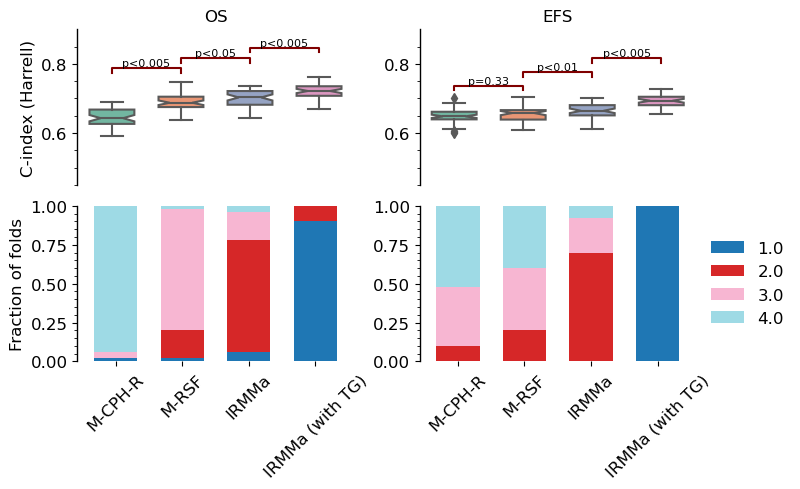

In [13]:
# Harrell's Concordance
# Fig 1
models = ['M-CPH-R', 'M-RSF', 'IRMMa', 'IRMMa (with TG)']
p_val_comparisons = [('M-CPH-R', 'M-RSF'), ('M-RSF', 'IRMMa'), ('IRMMa', 'IRMMa (with TG)')]

df_harrellc_os_atxyrs, rank_folds_harrellc_os_atxyrs, _ = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'C_index_harrell')
df_harrellc_efs_atxyrs, rank_folds_harrellc_efs_atxyrs, _ = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'C_index_harrell')

dfs_ = [df_harrellc_os_atxyrs, df_harrellc_efs_atxyrs] 
ranked_dfs_ = [rank_folds_harrellc_os_atxyrs, rank_folds_harrellc_efs_atxyrs]
heights_tex = [[0.76, 0.79, 0.82], [0.71, 0.75, 0.79]]
plot_metric_at_xyrs(models, 'C_index_harrell', dfs_, ranked_dfs_, 'C-index (Harrell)', p_val_comparisons, heights_tex)

In [14]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S2: Harrell\'s concordance comparison of existing risk methods with IRMMa (TG)'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S2: Harrell's concordance comparison of existing risk methods with IRMMa (TG)</strong></h1>

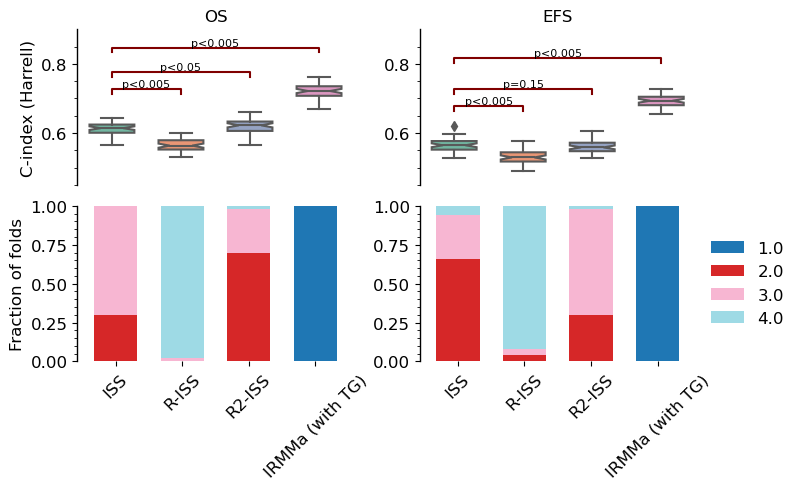

In [15]:
## After model selection and top genomic (TG) feature selection (using our hybrid approach)
models = ['ISS', 'R-ISS', 'R2-ISS', 'IRMMa (with TG)']
p_val_comparisons = [('ISS', 'R-ISS'), ('ISS', 'R2-ISS'), ('ISS', 'IRMMa (with TG)')]

# Fig 2.
df_harrellc_os_atxyrs, rank_folds_harrellc_os_atxyrs, _ = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'C_index_harrell')
df_harrellc_efs_atxyrs, rank_folds_harrellc_efs_atxyrs, _ = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'C_index_harrell')

dfs_ = [df_harrellc_os_atxyrs, df_harrellc_efs_atxyrs] 
ranked_dfs_ = [rank_folds_harrellc_os_atxyrs, rank_folds_harrellc_efs_atxyrs]
heights_tex = [[0.7, 0.75, 0.82], [0.65, 0.7, 0.79]]
plot_metric_at_xyrs(models, 'C_index_harrell', dfs_, ranked_dfs_, 'C-index (Harrell)', p_val_comparisons, heights_tex)

In [16]:
c_index_type = 'harrell' ; var_metric = 'C_index_' + c_index_type

In [17]:
# os
outcome_type = os_cv;

df_os_1yr = pd.read_csv(targ_dir + outcome_type + "_365_group_" + group + ".csv")
df_os_2yr = pd.read_csv(targ_dir + outcome_type + "_730_group_" + group + ".csv")
df_os_3yr = pd.read_csv(targ_dir + outcome_type + "_1095_group_" + group + ".csv")
df_os_4yr = pd.read_csv(targ_dir + outcome_type + "_1460_group_" + group + ".csv")
df_os_5yr = pd.read_csv(targ_dir + outcome_type + "_1825_group_" + group + ".csv")

df_os_1yr['time_yr'] = 1; df_os_2yr['time_yr'] = 2; df_os_3yr['time_yr'] = 3; df_os_4yr['time_yr'] = 4; df_os_5yr['time_yr'] = 5

df_os_cv_time = df_os_1yr.append(df_os_2yr, ignore_index=True).append(df_os_3yr, ignore_index=True).append(df_os_4yr, ignore_index=True).append(df_os_5yr, ignore_index=True)

In [18]:
# efs
outcome_type = efs_cv; 
df_efs_1yr = pd.read_csv(targ_dir + outcome_type + "_365_group_" + group + ".csv")
df_efs_2yr = pd.read_csv(targ_dir + outcome_type + "_730_group_" + group + ".csv")
df_efs_3yr = pd.read_csv(targ_dir + outcome_type + "_1095_group_" + group + ".csv")
df_efs_4yr = pd.read_csv(targ_dir + outcome_type + "_1460_group_" + group + ".csv")
df_efs_5yr = pd.read_csv(targ_dir + outcome_type + "_1825_group_" + group + ".csv")

df_efs_1yr['time_yr'] = 1; df_efs_2yr['time_yr'] = 2; df_efs_3yr['time_yr'] = 3; df_efs_4yr['time_yr'] = 4; df_efs_5yr['time_yr'] = 5

df_efs_cv_time = df_efs_1yr.append(df_efs_2yr, ignore_index=True).append(df_efs_3yr, ignore_index=True).append(df_efs_4yr, ignore_index=True).append(df_efs_5yr, ignore_index=True)

In [19]:
# rename
df_os_cv_time = pd.merge(df_os_cv_time, rename_x_id_df, left_on='X_ID', right_on='old')[['ID', 'time_yr', 'C_index_harrell', 'C_index_uno', 'Int_Brier_Score', 'NBLL', 'Fold']]
df_efs_cv_time = pd.merge(df_efs_cv_time, rename_x_id_df, left_on='X_ID', right_on='old')[['ID', 'time_yr',  'C_index_harrell', 'C_index_uno', 'Int_Brier_Score', 'NBLL', 'Fold']]

df_os_cv_time = df_os_cv_time.dropna(subset=[var_metric])
df_efs_cv_time = df_efs_cv_time.dropna(subset=[var_metric])

In [20]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S3: Harrell\'s C at times (years)'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S3: Harrell's C at times (years)</strong></h1>

In [21]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.constrained_layout.use' : True,
         'ytick.minor.visible': True
         }
pylab.rcParams.update(params)

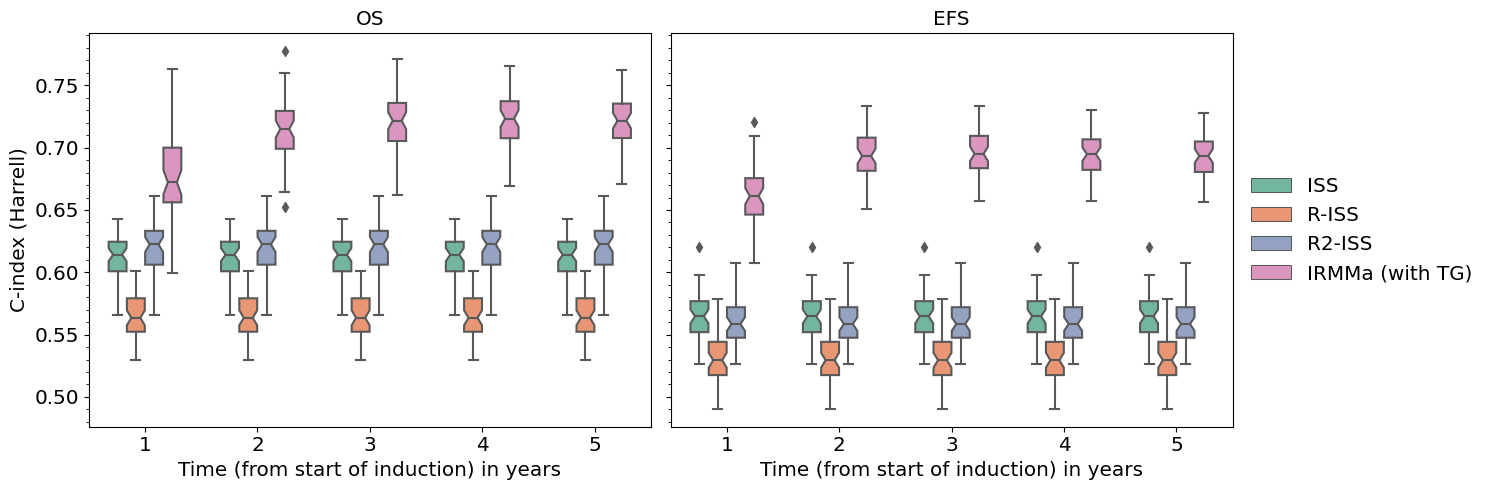

In [22]:
# C-index at times 1, 2, 3, 4, 5 years from start of induction
# Fig 3.

hue_order = ['ISS', 'R-ISS', 'R2-ISS', 'IRMMa (with TG)']

fig, axs = plt.subplots(1, 2, sharey=True)

ax_os, ax_efs = axs.flatten()

# os
sns.boxplot(x='time_yr', y=var_metric, hue='ID', width=0.65, palette='Set2', data=df_os_cv_time, notch=True, hue_order=hue_order, ax=ax_os);
ax_os.set_xlabel('Time (from start of induction) in years') ; ax_os.set_ylabel('C-index (Harrell)') ; ax_os.get_legend().remove()
ax_os.set_title('OS')

# efs
sns.boxplot(x='time_yr', y=var_metric, hue='ID', width=0.65, palette='Set2', data=df_efs_cv_time, notch=True, hue_order=hue_order, ax=ax_efs);
ax_efs.set_xlabel('Time (from start of induction) in years') ; ax_efs.set_ylabel('') ; ax_efs.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax_efs.set_title('EFS')
plt.tight_layout()

In [23]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('black','Uno\'s Concordance'))

</font><h1><strong><font color=black>Uno's Concordance</strong></h1>

In [24]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.constrained_layout.use' : True,
         'ytick.minor.visible': True
         }
pylab.rcParams.update(params)

In [25]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S4: Uno\'s Concordance'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S4: Uno's Concordance</strong></h1>

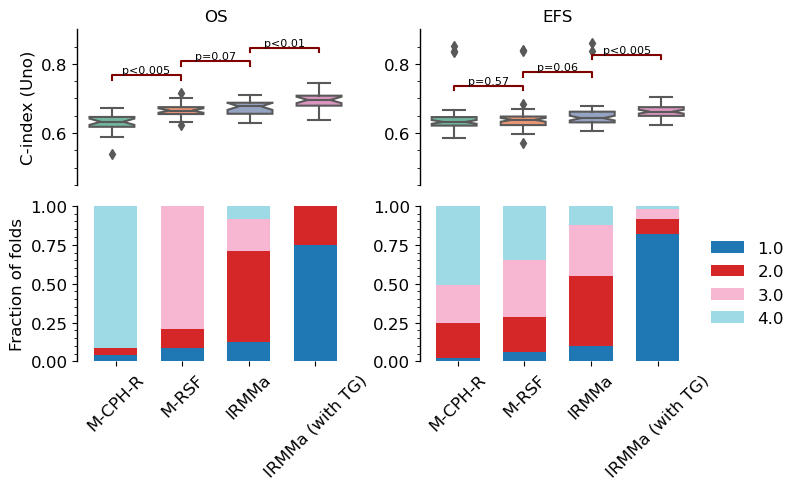

In [26]:
# Uno's Concordance
models = ['M-CPH-R', 'M-RSF', 'IRMMa', 'IRMMa (with TG)']
p_val_comparisons = [('M-CPH-R', 'M-RSF'), ('M-RSF', 'IRMMa'), ('IRMMa', 'IRMMa (with TG)')]

df_unoc_os_atxyrs, rank_folds_unoc_os_atxyrs, _ = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'C_index_uno')
df_unoc_efs_atxyrs, rank_folds_unoc_efs_atxyrs, _ = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'C_index_uno')

dfs_ = [df_unoc_os_atxyrs, df_unoc_efs_atxyrs] 
ranked_dfs_ = [rank_folds_unoc_os_atxyrs, rank_folds_unoc_efs_atxyrs]
heights_tex = [[0.74, 0.78, 0.82], [0.71, 0.75, 0.8]]
plot_metric_at_xyrs(models, 'C_index_uno', dfs_, ranked_dfs_, 'C-index (Uno)', p_val_comparisons, heights_tex)

In [27]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S5: Uno\'s concordance comparison of existing risk methods with IRMMa (TG)'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S5: Uno's concordance comparison of existing risk methods with IRMMa (TG)</strong></h1>

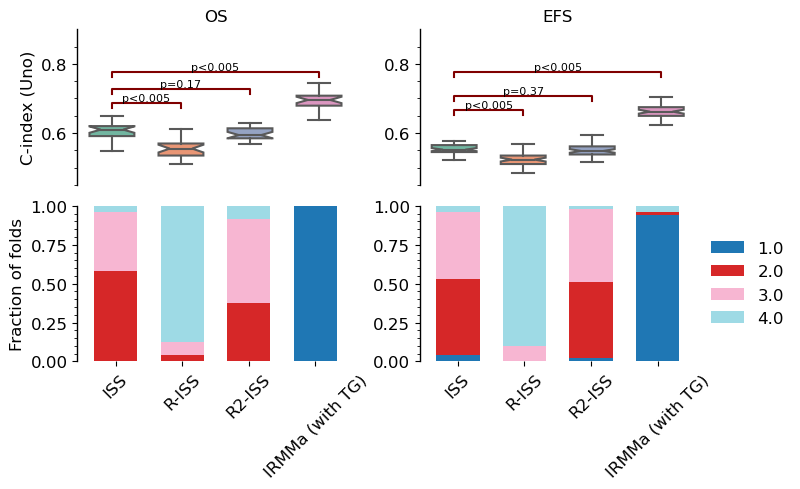

In [28]:
## After model selection and top genomic (TG) feature selection (using our hybrid approach)
models = ['ISS', 'R-ISS', 'R2-ISS', 'IRMMa (with TG)']
p_val_comparisons = [('ISS', 'R-ISS'), ('ISS', 'R2-ISS'), ('ISS', 'IRMMa (with TG)')]

# Fig 2.
df_unoc_os_atxyrs, rank_folds_unoc_os_atxyrs, _ = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'C_index_uno')
df_unoc_efs_atxyrs, rank_folds_unoc_efs_atxyrs, _ = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'C_index_uno')

dfs_ = [df_unoc_os_atxyrs, df_unoc_efs_atxyrs] 
ranked_dfs_ = [rank_folds_unoc_os_atxyrs, rank_folds_unoc_efs_atxyrs]
heights_tex = [[0.66, 0.7, 0.75], [0.64, 0.68, 0.75]]

plot_metric_at_xyrs(models, 'C_index_uno', dfs_, ranked_dfs_, 'C-index (Uno)', p_val_comparisons, heights_tex)

In [29]:
c_index_type = 'uno' ; var_metric = 'C_index_' + c_index_type

In [30]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S6: Uno\'s C at different times (years)'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S6: Uno's C at different times (years)</strong></h1>

In [31]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.constrained_layout.use' : True,
         'ytick.minor.visible': True
         }
pylab.rcParams.update(params)

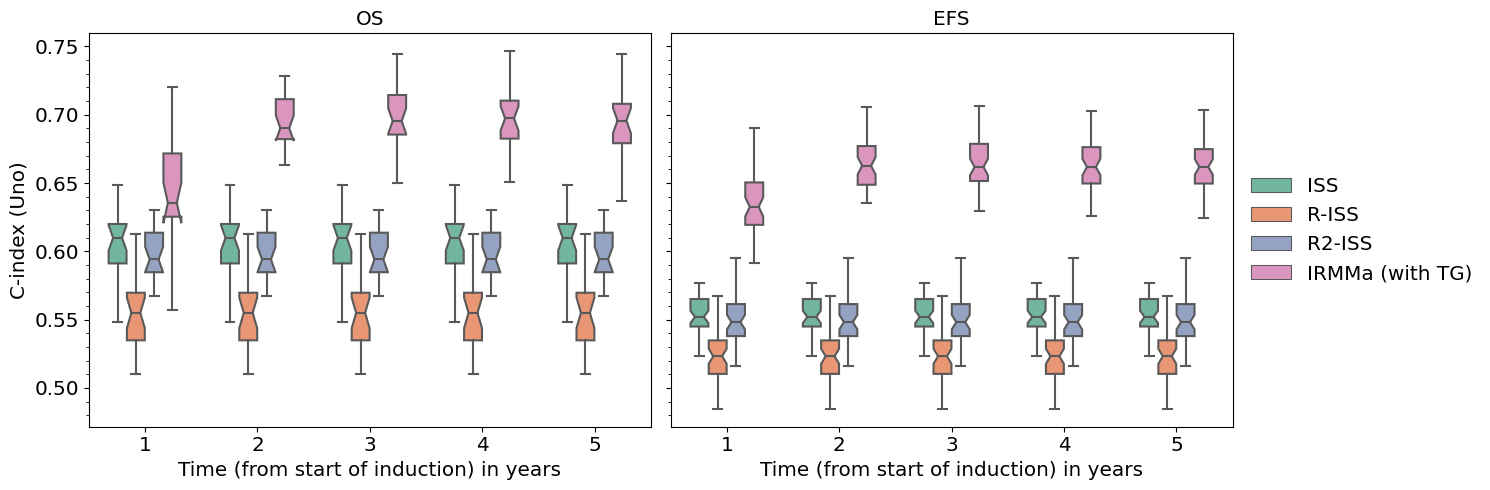

In [32]:
# C-index at times 1, 2, 3, 4, 5 years from start of induction
# Fig 3.

hue_order = ['ISS', 'R-ISS', 'R2-ISS', 'IRMMa (with TG)']

fig, axs = plt.subplots(1, 2, sharey=True)

ax_os, ax_efs = axs.flatten()

# os
sns.boxplot(x='time_yr', y=var_metric, hue='ID', width=0.65, palette='Set2', data=df_os_cv_time, notch=True, hue_order=hue_order, ax=ax_os, showfliers=False);
ax_os.set_xlabel('Time (from start of induction) in years') ; ax_os.set_ylabel('C-index (Uno)') ; ax_os.get_legend().remove()
ax_os.set_title('OS')

# efs
sns.boxplot(x='time_yr', y=var_metric, hue='ID', width=0.65, palette='Set2', data=df_efs_cv_time, notch=True, hue_order=hue_order, ax=ax_efs, showfliers=False);
ax_efs.set_xlabel('Time (from start of induction) in years') ; ax_efs.set_ylabel('') ; ax_efs.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax_efs.set_title('EFS')
plt.tight_layout()

In [33]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('purple','1.1.2 Calibrative performance'))

</font><h1><strong><font color=purple>1.1.2 Calibrative performance</strong></h1>

***
We use Concordance measures by Integrated Brier Score (BS) and Integrated Negative Binomial Log-likelihood (NBLL)
***

In [34]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('black','Brier Score'))

</font><h1><strong><font color=black>Brier Score</strong></h1>

In [35]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.constrained_layout.use' : True,
         'ytick.minor.visible': True
         }
pylab.rcParams.update(params)

In [36]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S7: Calibrative comparison of existing risk methods'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S7: Calibrative comparison of existing risk methods</strong></h1>

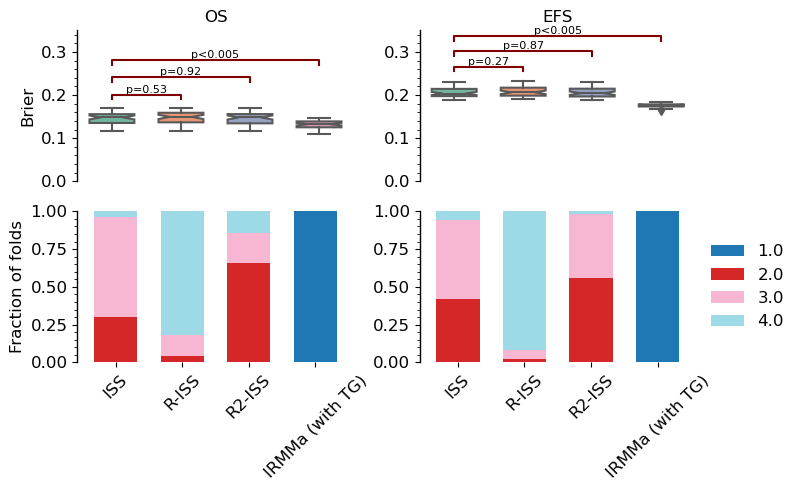

In [37]:
# Fig 2.
df_brier_os_atxyrs, rank_folds_brier_os_atxyrs, _ = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'Int_Brier_Score')
df_brier_efs_atxyrs, rank_folds_brier_efs_atxyrs, _ = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'Int_Brier_Score')

dfs_ = [df_brier_os_atxyrs, df_brier_efs_atxyrs] 
ranked_dfs_ = [rank_folds_brier_os_atxyrs, rank_folds_brier_efs_atxyrs]
heights_tex = [[0.18, 0.22, 0.26, 0.16], [0.245, 0.28, 0.315, 0.2]]

plot_metric_at_xyrs(models, 'Int_Brier_Score', dfs_, ranked_dfs_, 'Brier', p_val_comparisons, heights_tex)

In [38]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('black','NBLL'))

</font><h1><strong><font color=black>NBLL</strong></h1>

In [39]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S8: NBLL comparison of existing risk methods'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S8: NBLL comparison of existing risk methods</strong></h1>

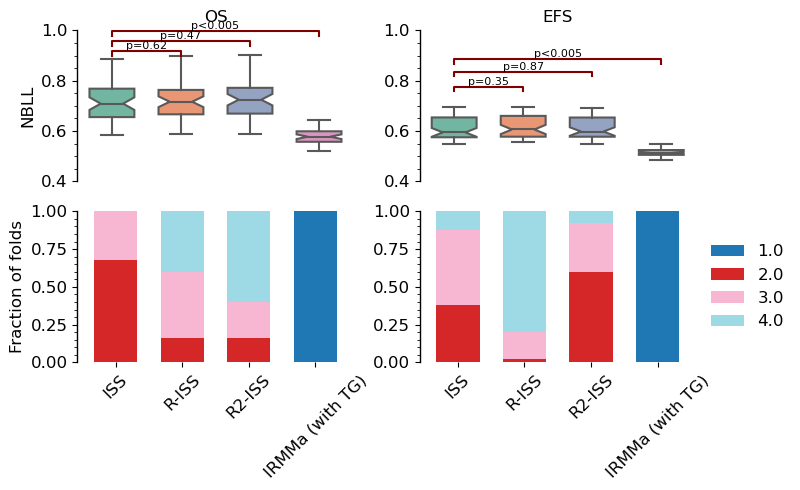

In [40]:
# Fig 2.
df_nbll_os_atxyrs, rank_folds_nbll_os_atxyrs, _ = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'NBLL')
df_nbll_efs_atxyrs, rank_folds_nbll_efs_atxyrs, _ = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'NBLL')

dfs_ = [df_nbll_os_atxyrs, df_nbll_efs_atxyrs] 
ranked_dfs_ = [rank_folds_nbll_os_atxyrs, rank_folds_nbll_efs_atxyrs]
heights_tex = [[0.88, 0.92, 0.96, 0.69], [0.74, 0.8, 0.85, 0.6]]

plot_metric_at_xyrs(models, 'NBLL', dfs_, ranked_dfs_, 'NBLL', p_val_comparisons, heights_tex)

In [41]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#f67b51','1.2 Feature ranking and selection'))

</font><h1><strong><font color=#f67b51>1.2 Feature ranking and selection</strong></h1>

***
* 1. Many methods of feature ranking exist. From greedy stepwise linear forward/backward approaches to permutation importance. Our surv neural net model is leveraged at different states (P1/P2) to rank inidividual features. They are also aggregated into sub group of clinical, genomic.. to determine overall group impact to OS, EFS.
* 2. For genomic feature selection, rather than conservative or elaborate search through a very large feature space, we explore a hybrid conserative genomic feature selection from univariate high impact features and model found features. 
***

In [42]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('purple','1.2.1 Discriminatory based feature ranking'))

</font><h1><strong><font color=purple>1.2.1 Discriminatory based feature ranking</strong></h1>

In [43]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S9: Feature ranking based on permutation importance'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S9: Feature ranking based on permutation importance</strong></h1>

In [44]:
model = 'neural_cox_non_prop'
output_files = glob.glob(base_dir + "/data_out/expt_1/permut_feat_imps/compose/*_all_feat_*" + model + "*.csv")
data_list = []
for filename in output_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    data_list.append(df)
    df['fold'] = filename.split('/')[-1].split('_')[1]

concat_feats = pd.concat(data_list, axis=0, ignore_index=True)

concat_feats = concat_feats[['group', 'class_generic', 'weight', 'std', 'fold', 'column_id']]

overall_fea_class = pd.read_excel(base_dir + '/data_in/legend_PMMM_2022.xlsx')
concat_feats = pd.merge(concat_feats, overall_fea_class[['column_id', 'display_id']],
                        on='column_id', how='inner')

unique_feat_groups = concat_feats['class_generic'].unique().tolist()
color = ['deepskyblue', 'pink', 'orange', 'forestgreen', 'violet', 'gray']
concat_feats['color'] = ''
for i, item in enumerate(unique_feat_groups):
    # print(item, color[i])
    concat_feats['color'].mask(concat_feats['class_generic'] == item, color[i], inplace=True)

concat_feats['display_id'] = concat_feats['display_id'].str.replace(r'(CNV_)|(CNV\.SNV_)|(SNV_)', '', regex=True)

unique_states = ['Progress (P1)', 'Progress & deceased (P1)', 'Progress (P2)', 'Progress & deceased (P2)', 'Non-progress & deceased (P2)'] # concat_feats['group'].unique() # states


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


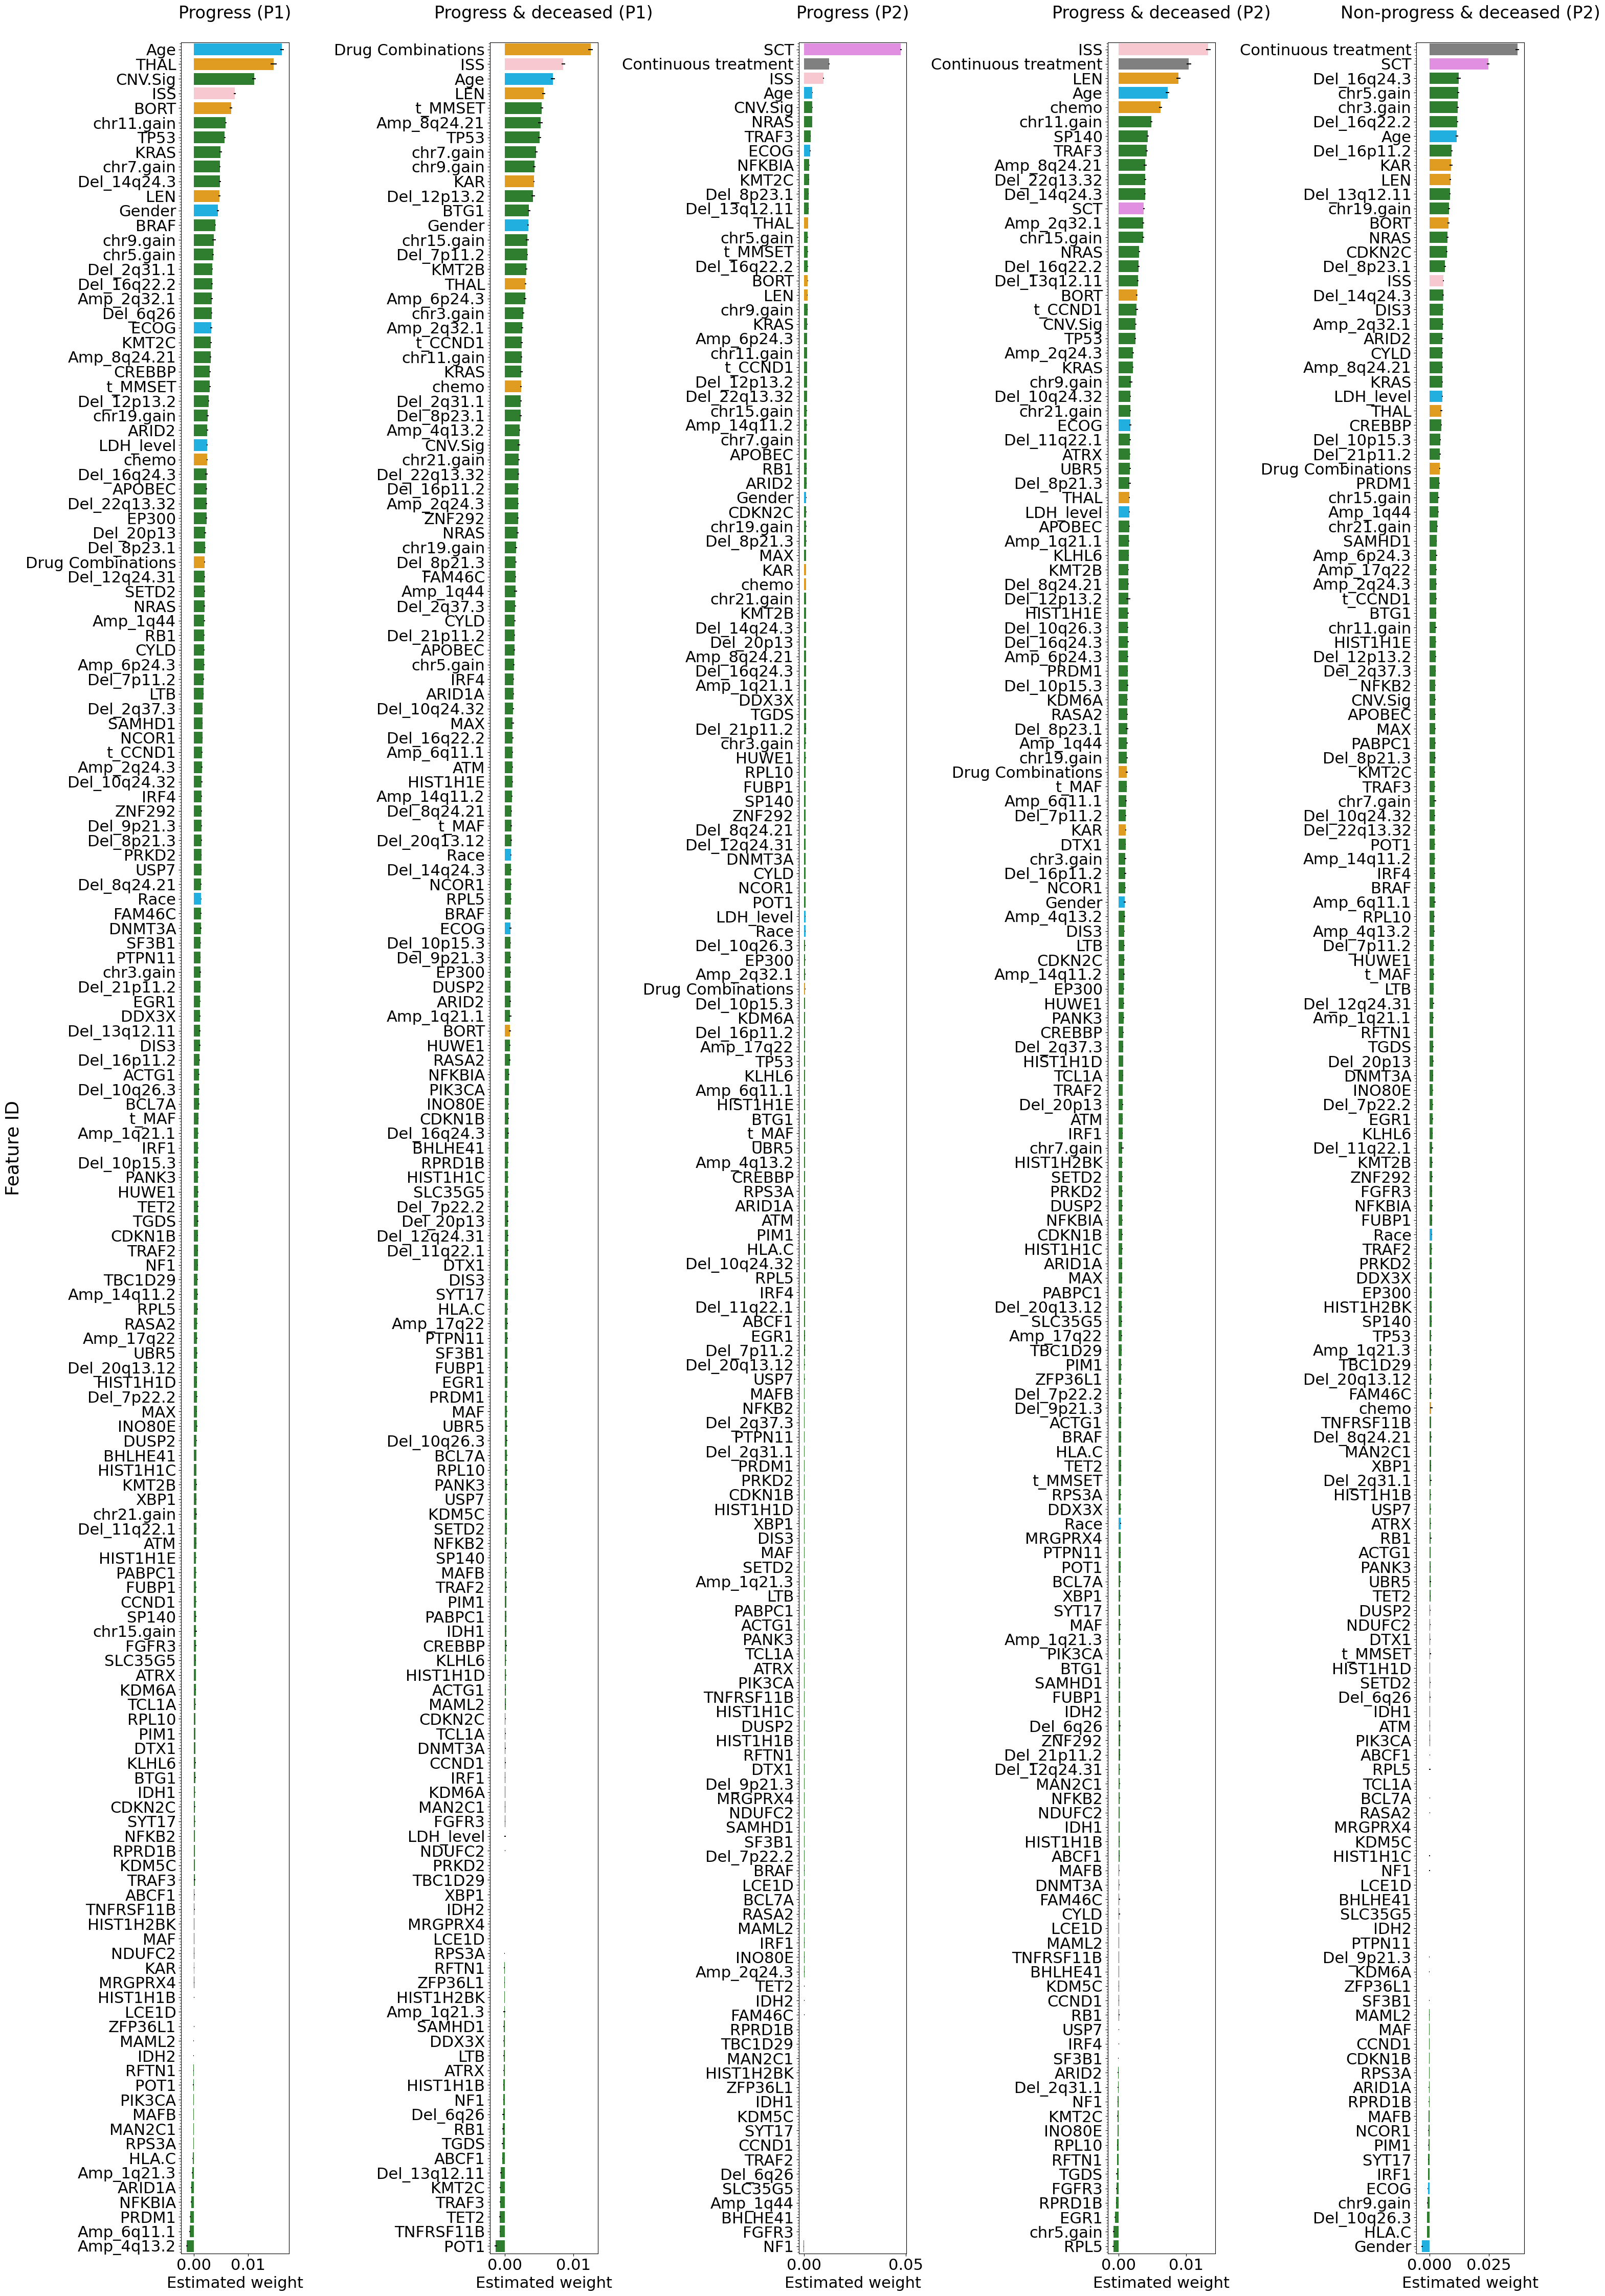

In [45]:
fig, ax = plt.subplots(ncols=5, figsize=(30, 45))
for ind, state in enumerate(unique_states):
    df_inst = concat_feats[(concat_feats['group'] == state)]

    df_inst['std'] = df_inst['std'] / (df_inst[['fold']].max(axis=1) + 1) # np.sqrt(df_inst[['fold']].max(axis=1) + 1)

    df_inst = df_inst.groupby(['column_id', 'display_id', 'color'])['weight', 'std'].mean().reset_index()
    df_inst = df_inst.sort_values(by='weight', ascending=False)

    # df_inst = df_inst.iloc[:50] # top 50 feats

    sns.barplot(y="display_id", x="weight", orient='h', xerr= df_inst['std'] * 1, palette=df_inst['color'], data=df_inst, ax=ax[ind])
    if ind == 0:
        ax[ind].set_ylabel("Feature ID", fontsize=26, fontname="Arial")
    else:
        ax[ind].set_ylabel('')
    ax[ind].set_xlabel("Estimated weight", fontsize=22, fontname="Arial")
    ax[ind].tick_params(axis='both', which='major', labelsize=22)
    ax[ind].set_title(state + '\n', fontsize=24, fontname="Arial")
    fig.tight_layout()

In [46]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S10: Aggregated group ranking'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S10: Aggregated group ranking</strong></h1>

In [47]:
dict_class_color = (dict(zip(concat_feats['class_generic'], concat_feats['color'])));
df_class_color = pd.DataFrame(dict_class_color.items(), columns=['class_generic', 'color'])

In [48]:
df_feat_size_class_generic = pd.DataFrame(overall_fea_class.groupby('class_generic')['display_id'].count().reset_index().rename(columns={'display_id': 'num_feats'}))
# print(df_feat_size_class_generic)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


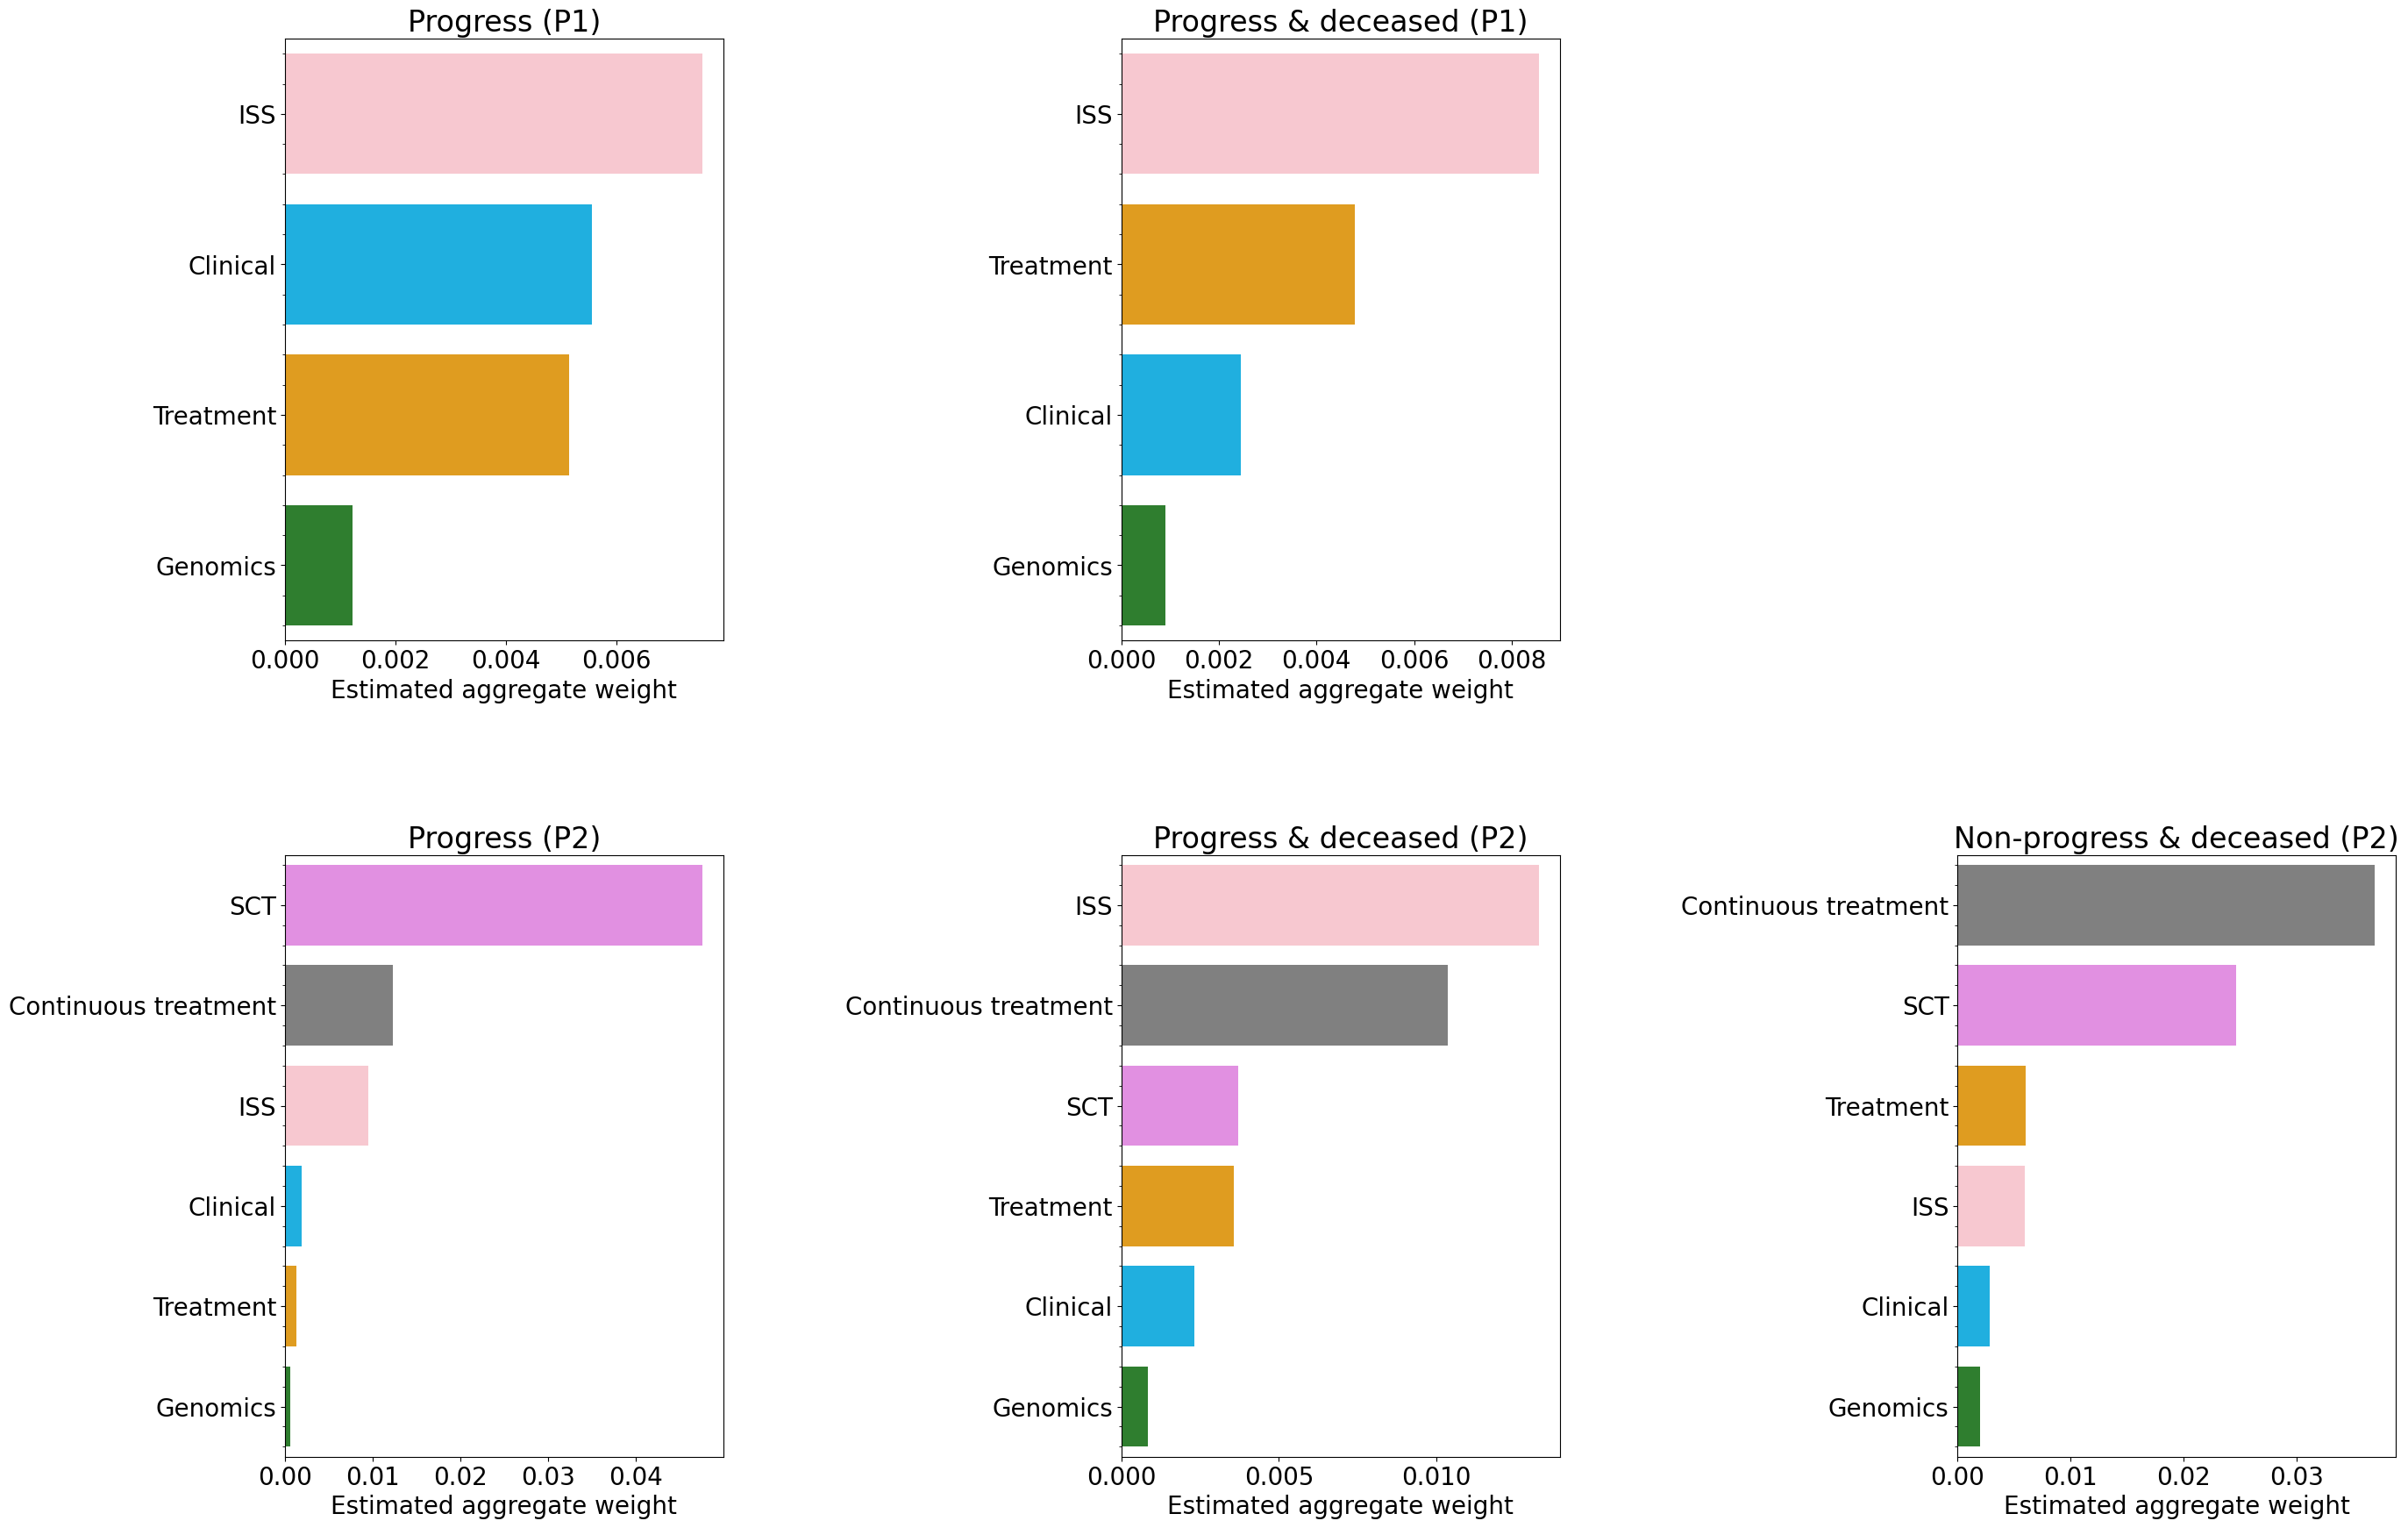

In [49]:
def func_re_weight(df):
    df['re-weighted'] = (1 - (df['num_feats'] / df['num_feats'].sum()))
    df['re-weighted'] = df['weight'] * (1 - df['num_feats'] / df['num_feats'].sum())
    return df.sort_values('re-weighted', ascending=False)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
axes = ax.flatten()

for ind, state in enumerate(unique_states):
    if ind in range(2, 5):
        ind +=1
    ax = axes[ind]

    df_state = concat_feats[concat_feats['group'] == state].groupby('class_generic')['weight'].mean()
    df_weight_class_color = ft.reduce(lambda left, right: pd.merge(left, right, on='class_generic'), 
                         [df_state.reset_index(), df_feat_size_class_generic, 
                          df_class_color])

    df_weight_class_color['weight'] = df_weight_class_color['weight']# .mul(100)
    df_weight_class_color = df_weight_class_color.sort_values('weight', ascending=False)

    sns.barplot(data=df_weight_class_color, y = 'class_generic', x = 'weight', orient = 'h', 
                        palette=df_weight_class_color['color'], ax=ax)

    ax.set_xlabel("Estimated aggregate weight", fontsize=20, fontname="Arial")
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(state + '\n', fontsize=26, fontname="Arial")
    ax.set_title(state, fontsize=24)

fig.delaxes(axes[2])
fig.tight_layout(pad=10)

In [52]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('purple','1.2.1 Genomic Feature selection'))

</font><h1><strong><font color=purple>1.2.1 Genomic Feature selection</strong></h1>

```
Psuedo code
univ_feats_p_less_than_01 = univariate based filtering to get genomic features with p-val (<0.01) for OS and PFS 
baseline_features = ISS + Clinical + Rec. transloc + SCT + Cont. treat + Therapy + Genomics + univ_feats_p_less_than_01
pool_to_select = univ_feats_p_less_than_05 - univ_feats_p_less_than_01
cumul_ = empty
for individual_feature in pool_to_select:
    if first individual feature:
        cumul_ = baseline_features
    cumul_ = cumul_ + individual_feature
    our_approach(cumul)
```

In [53]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Table 1: High-impact genomic features with p-val < 0.01'))

</font><h1><strong><font color=#cf2518>Supplementary Table 1: High-impact genomic features with p-val < 0.01</strong></h1>

In [54]:
## Univariate features

# 1. Literature / known high impact features on our dataset
df_uni_p_05 = pd.read_csv(targ_dir + 'df_feat_uni_p_val_05.csv')
df_uni = df_uni_p_05[(df_uni_p_05['PFS.pvalue'] < 0.01) & (df_uni_p_05['OS.pvalue'] < 0.01)][['Genomic.Feature', 'OS.pvalue', 'PFS.pvalue']]
print(df_uni.to_markdown(tablefmt="grid"))

+----+-------------------+-------------+--------------+
|    | Genomic.Feature   |   OS.pvalue |   PFS.pvalue |
+====+===================+=============+==============+
|  0 | APOBEC            | 1.11247e-06 |  0.00550556  |
+----+-------------------+-------------+--------------+
|  1 | CNV_Amp_1q21.1    | 2.09274e-08 |  2.28917e-07 |
+----+-------------------+-------------+--------------+
|  2 | CNV_Amp_1q21.3    | 2.57625e-10 |  4.53402e-07 |
+----+-------------------+-------------+--------------+
|  3 | CNV_Amp_1q44      | 2.26001e-10 |  5.27194e-06 |
+----+-------------------+-------------+--------------+
|  5 | CNV_Del_10q26.3   | 0.00663625  |  0.00588457  |
+----+-------------------+-------------+--------------+
|  7 | CNV_Del_13q12.11  | 0.00802109  |  0.0058122   |
+----+-------------------+-------------+--------------+
| 11 | CNV.Sig           | 3.86651e-08 |  1.75503e-06 |
+----+-------------------+-------------+--------------+
| 13 | CNV.SNV_FUBP1     | 0.00341116  |  0.0014

In [55]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S11: Model selected top disciriminative features based on improvement from baseline'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S11: Model selected top disciriminative features based on improvement from baseline</strong></h1>

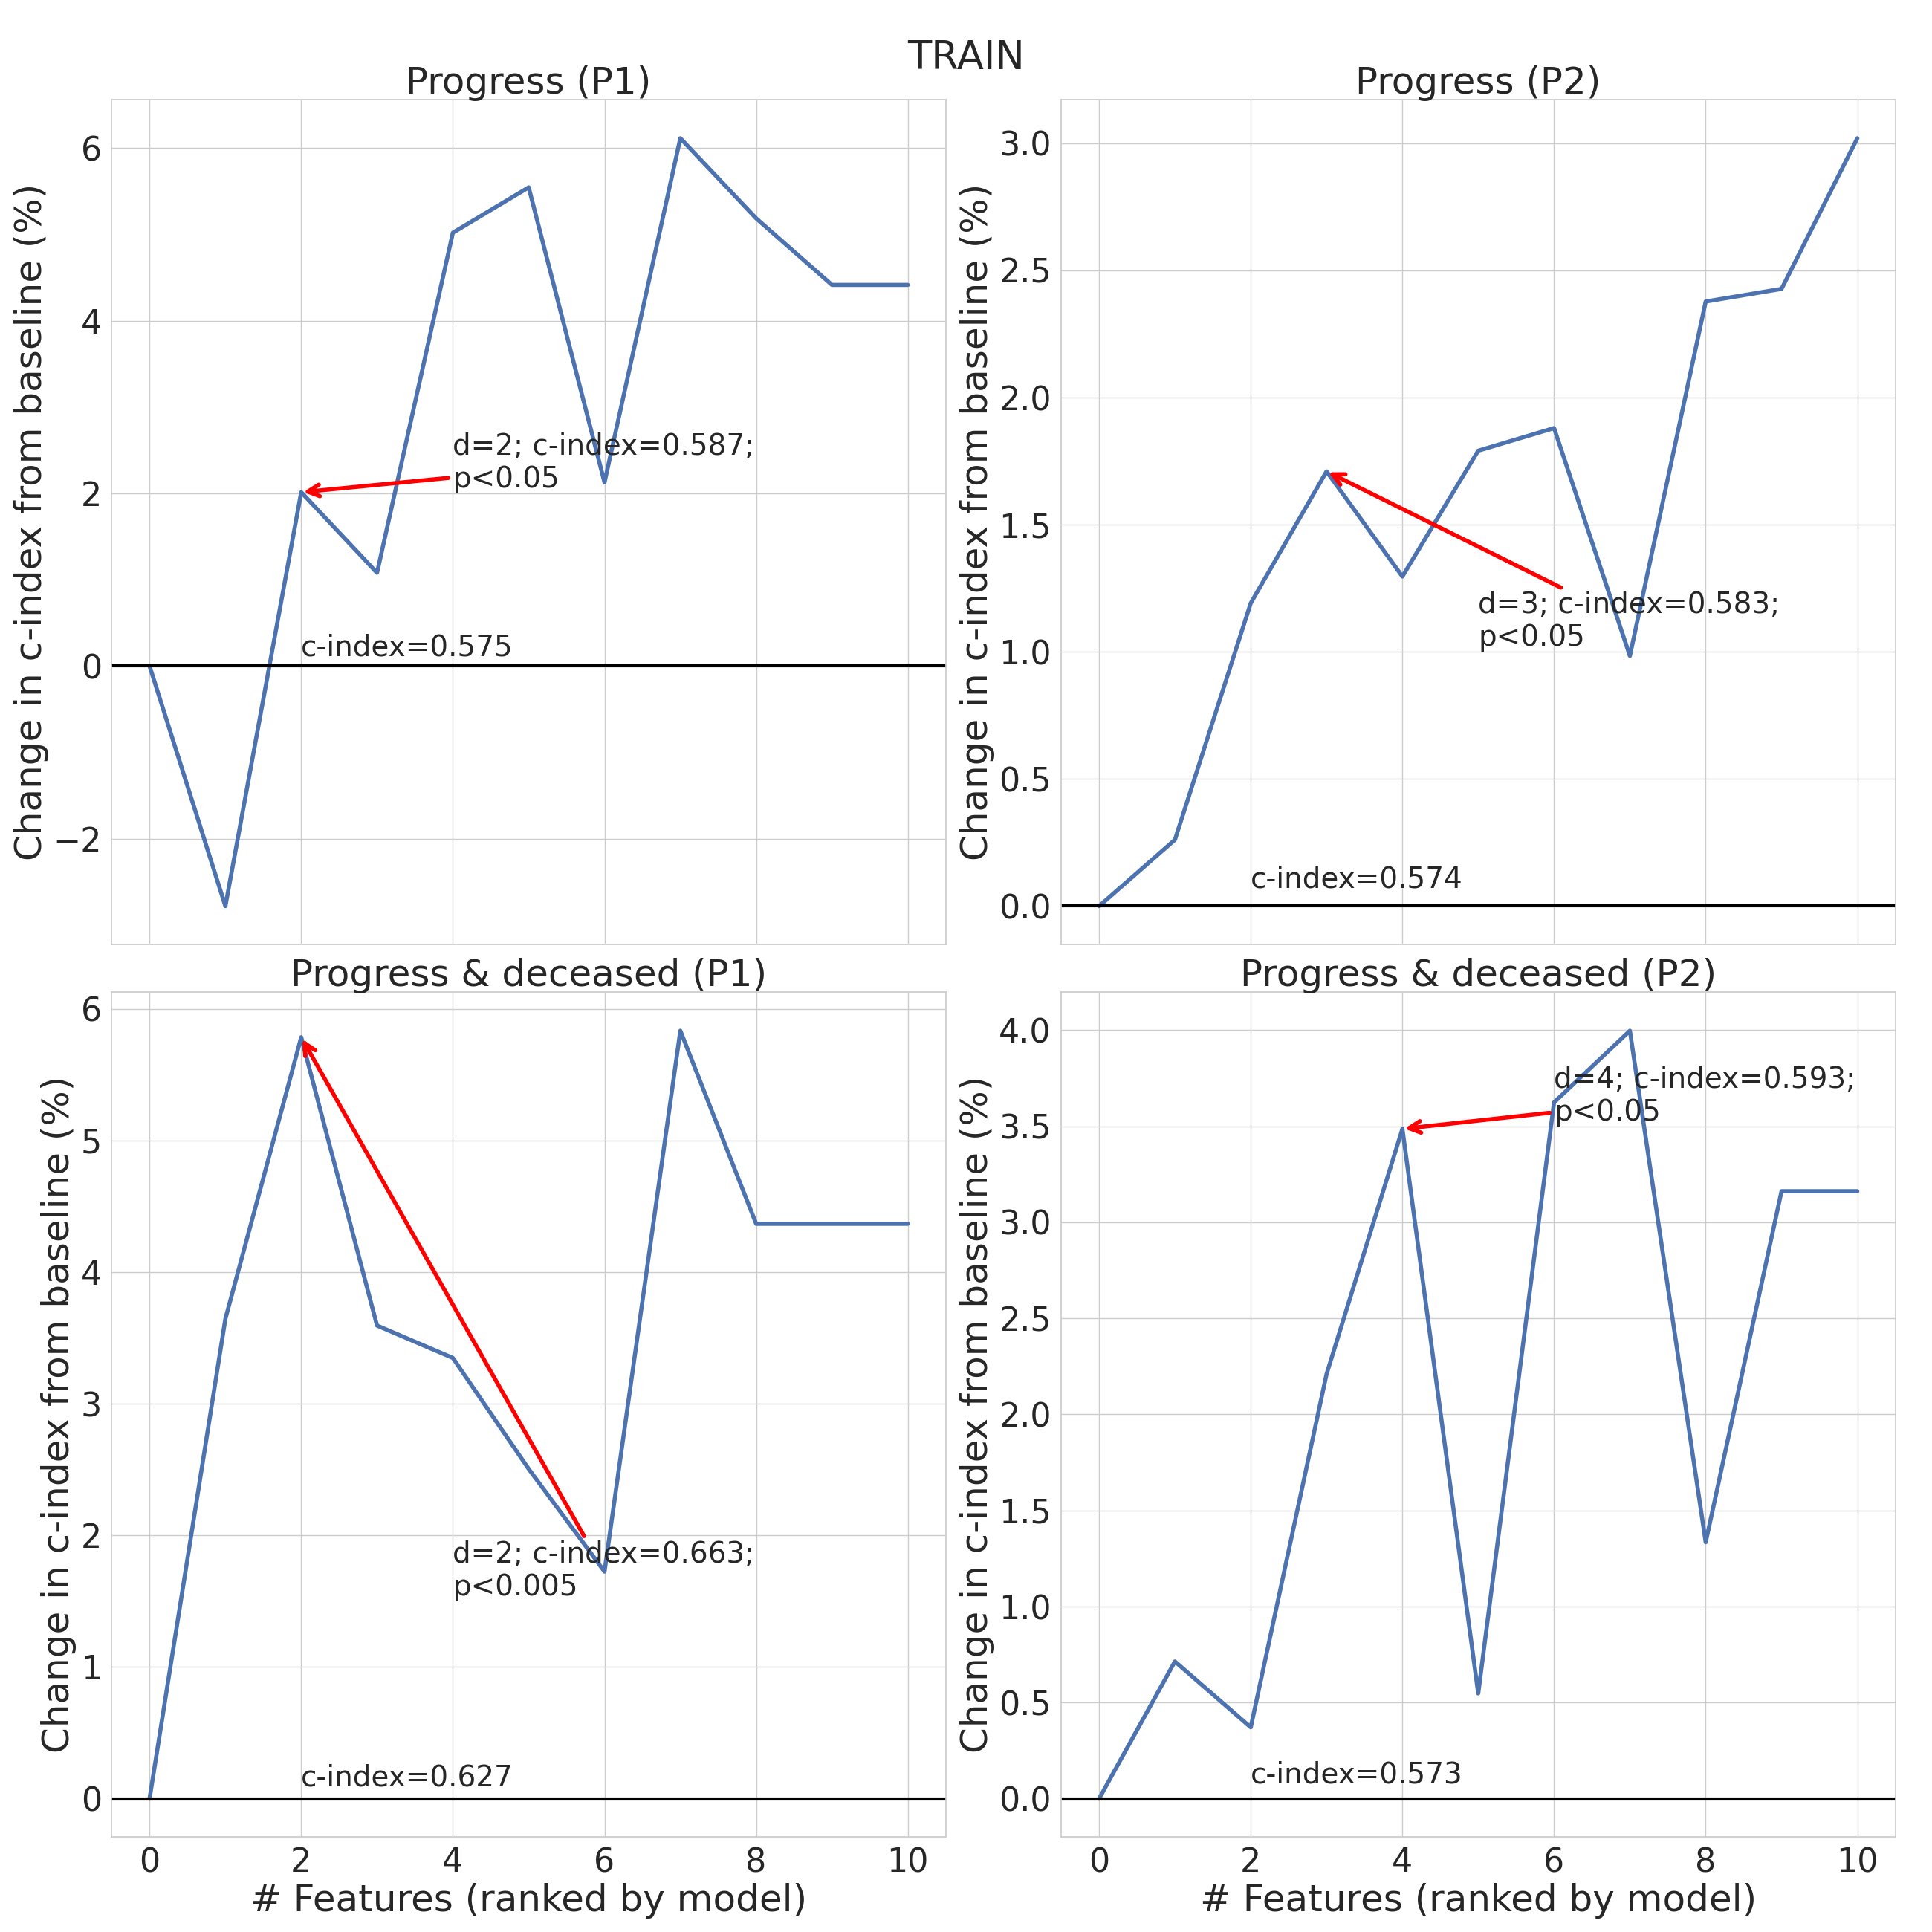

In [56]:
# CNV|Mutations|CNV_Mutations|Translocation, [2, 2, 3, 4] features
Image(targ_dir + 'change_in_c_index_state_train.png', width=450) 

In [57]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S12: Heatmap of model selected genomic features by state'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S12: Heatmap of model selected genomic features by state</strong></h1>

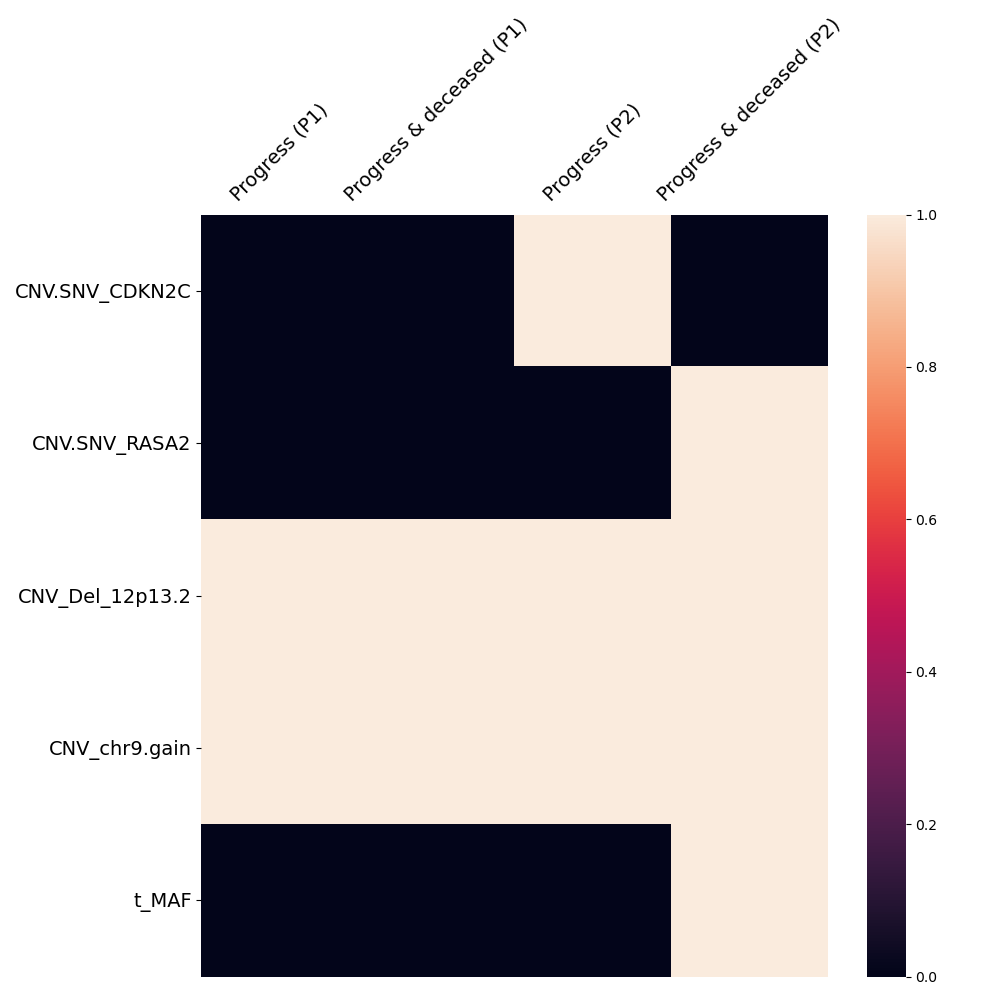

In [58]:
# CNV|Mutations|CNV_Mutations|Translocation, [2, 2, 3, 4] features
from IPython.display import Image
Image(targ_dir + 'heatmap_importance_gen_across_states_train.png', width=450) 

In [59]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#f67b51','1.3 Cumulative additive effect of features to prognostic discrimination'))

</font><h1><strong><font color=#f67b51>1.3 Cumulative additive effect of features to prognostic discrimination</strong></h1>

```
We show here through our approach of forward addition and reverse subtraction of feature groups, the order in which they are inserted/removed matters. The relative importance varies accordingly.
```

In [60]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S13: Forward effect on Concordance'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S13: Forward effect on Concordance</strong></h1>

In [61]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.constrained_layout.use' : True,
         'ytick.minor.visible': True
         }
pylab.rcParams.update(params)

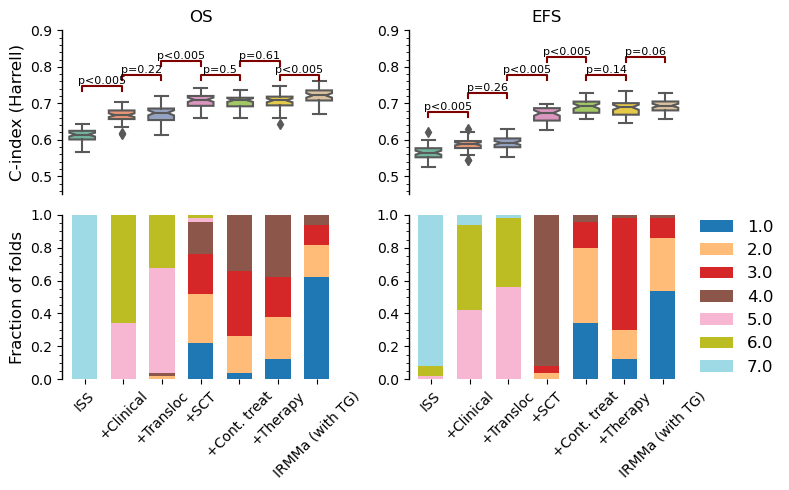

In [62]:
# Fig
models = ['ISS', '+Clinical', '+Transloc', '+SCT', '+Cont. treat', '+Therapy', 'IRMMa (with TG)']
p_val_comparisons = [('ISS', '+Clinical'), ('+Clinical', '+Transloc'),
                    ('+Transloc', '+SCT'), ('+SCT', '+Cont. treat'), 
                     ('+Cont. treat', '+Therapy'), ('+Therapy', 'IRMMa (with TG)')]

df_harrellc_os_atxyrs, rank_folds_harrellc_os_atxyrs, df_sub_c_ind_vals_os_atxyrs = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'C_index_harrell')
df_harrellc_efs_atxyrs, rank_folds_harrellc_efs_atxyrs, df_sub_c_ind_vals_efs_atxyrs = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'C_index_harrell')

dfs_ = [df_harrellc_os_atxyrs, df_harrellc_efs_atxyrs] 
ranked_dfs_ = [rank_folds_harrellc_os_atxyrs, rank_folds_harrellc_efs_atxyrs]
heights_tex = [[0.72, 0.75, 0.79, 0.75, 0.79, 0.75], [0.65, 0.7, 0.75, 0.8, 0.75, 0.8]]
plot_metric_at_xyrs(models, 'C_index_harrell', dfs_, ranked_dfs_, 'C-index (Harrell)', p_val_comparisons, heights_tex)

In [63]:
'''
Scorer to understand overall feature group importance
'''
def scorer(base, comp):
    score = comp['median'] - (base['median'])
    score = score /base['median']
    score = score * ( 1 +
            (comp['Group Feat. size']/comp['Accum. Feat. size']) - (base['Group Feat. size']/base['Accum. Feat. size'])
            )
    return score * 100


def relative_importance(df_sub_c_ind_vals, order='forward'):
    df_median = df_sub_c_ind_vals.median().sort_values(ascending=True)

    # [size of group, cumulative total]
    
    if order == 'forward':
        feat_size = {
             'ISS': [1,1], '+Clinical': [5, 6], '+Transloc': [3,9], '+SCT': [1,10],
             '+Cont. treat': [1,11], '+Therapy': [11,17], 'IRMMa (with TG)': [17,34], 'IRMMa': [153,153], 
            'ISS+SCT': [1, 2],'ISS+Cont. treat': [1, 2], 'ISS+Therapy': [1, 7],
            'ISS+TopGen': [1, 18], 'ISS+Rec. Transloc': [1, 4]
             }
    elif order == 'backward':
        feat_size = {
            'Top Genomics': [17,17], '(R_)+Therapy': [6,23],
            '(R_)+Cont. treat': [1,24],  '(R_)+SCT': [1,25], '(R_)+Transloc': [3,28],
            '(R_)+Clinical': [5, 33], '(R_)+ISS': [1,34]}

    df_median = pd.DataFrame(df_median).rename(columns={0: 'median'})
    rename_df = pd.DataFrame.from_dict(feat_size, orient='index')\
                        .reset_index().rename(columns={'index': 'group',
                              0: 'Group Feat. size', 1: 'Accum. Feat. size'})

    df_median = pd.merge(df_median, rename_df, left_index=True, right_on='group')
    df_median = df_median[(df_median['group'] != 'R-ISS') & (df_median['group'] != 'All features') &
                                (df_median['group'] != 'R2-ISS')]
    df_median = df_median.set_index('group')

    df_median_cp = df_median.copy()
    
    df_score = pd.DataFrame(columns=['score'])

    if order == 'forward':
        df_score.loc['ISS => +Clinical'] = scorer(df_median_cp.loc['ISS'], df_median_cp.loc['+Clinical'])
        df_score.loc['ISS => +Transloc'] = scorer(df_median_cp.loc['ISS'], df_median_cp.loc['+Transloc'])
        df_score.loc['ISS => +SCT'] = scorer(df_median_cp.loc['ISS'], df_median_cp.loc['+SCT'])
        df_score.loc['ISS => +Cont.treat'] = scorer(df_median_cp.loc['ISS'], df_median_cp.loc['+Cont. treat'])
        df_score.loc['ISS => +Therapy'] = scorer(df_median_cp.loc['ISS'], df_median_cp.loc['+Therapy'])
        df_score.loc['ISS => +Top genomics'] = scorer(df_median_cp.loc['ISS'], df_median_cp.loc['IRMMa (with TG)'])

    elif order == 'backward':
        df_score.loc['TG => +Therapy'] = scorer(df_median_cp.loc['Top Genomics'], df_median_cp.loc['(R_)+Therapy'])
        df_score.loc['TG => +Cont.treat'] = scorer(df_median_cp.loc['Top Genomics'], df_median_cp.loc['(R_)+Cont. treat'])
        df_score.loc['TG => +SCT'] = scorer(df_median_cp.loc['Top Genomics'], df_median_cp.loc['(R_)+SCT'])
        df_score.loc['TG => +Transloc'] = scorer(df_median_cp.loc['Top Genomics'], df_median_cp.loc['(R_)+Transloc'])
        df_score.loc['TG => +Clinical'] = scorer(df_median_cp.loc['Top Genomics'], df_median_cp.loc['(R_)+Clinical'])
        df_score.loc['TG => +ISS'] = scorer(df_median_cp.loc['Top Genomics'], df_median_cp.loc['(R_)+ISS'])

    return df_score


def plot_relative_imp(ax, df_score, titl):
    # df_score = df_score.sort_values(by='score', ascending=False).reset_index()
    df_score = df_score.reset_index()
    sns.barplot(x='score', y='index', data=df_score, palette='coolwarm', orient='h', ax=ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_title(titl)
    if titl == 'EFS':
        ax.set_xlabel('Relative Feature Group Impact Score (%)')
        ax.set_ylabel('')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.axvline(x=0)

    return ax

In [64]:
params = {'legend.fontsize': 'medium',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.constrained_layout.use' : True,
         }
pylab.rcParams.update(params)

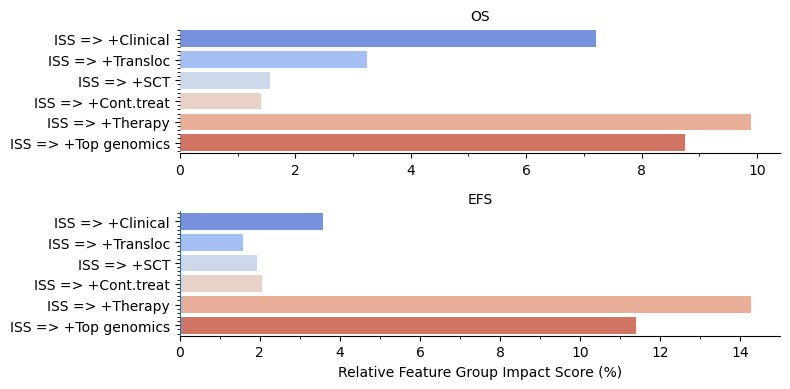

In [65]:
models = ['ISS', '+Clinical', '+Transloc', '+SCT', '+Cont. treat', '+Therapy', 'IRMMa (with TG)', 'ISS+TopGen']

df_harrellc_os_atxyrs, rank_folds_harrellc_os_atxyrs, df_sub_c_ind_vals_os_atxyrs = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'C_index_harrell')
df_harrellc_efs_atxyrs, rank_folds_harrellc_efs_atxyrs, df_sub_c_ind_vals_efs_atxyrs = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'C_index_harrell')

df_score_os = relative_importance(df_sub_c_ind_vals_os_atxyrs)
df_score_efs = relative_importance(df_sub_c_ind_vals_efs_atxyrs)

fig, (ax0, ax1) = plt.subplots(2, 1)
for (ax, df_score, titl) in [(ax0, df_score_os, 'OS'), (ax1, df_score_efs, 'EFS')]:
    ax = plot_relative_imp(ax, df_score, titl)

plt.tight_layout()

In [66]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S14: Cumulative effect (in reversed order) on Concordance'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S14: Cumulative effect (in reversed order) on Concordance</strong></h1>

In [67]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.constrained_layout.use' : True,
         'ytick.minor.visible': True
         }
pylab.rcParams.update(params)

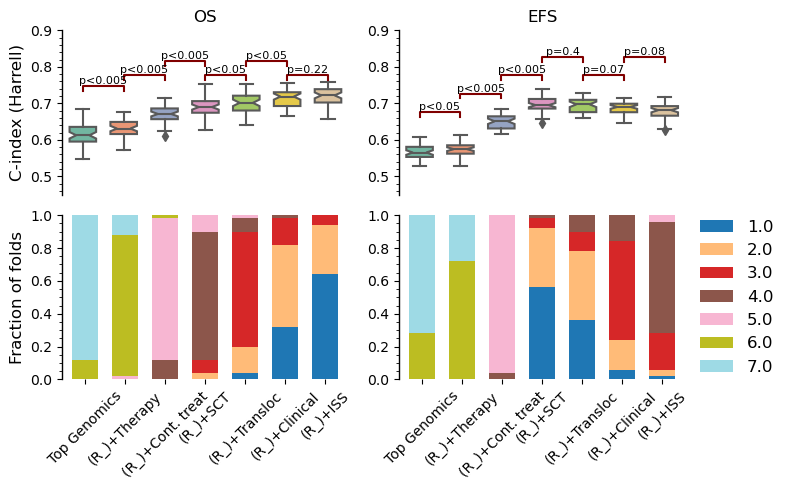

In [68]:
models = ['+ISS', '+Clinical', '+Transloc', '+SCT', '+Cont. treat', '+Therapy', 'Top Genomics']
models.reverse()
models = [str('(R_)'+item) if (item != 'Top Genomics') else item for item in models]

p_val_comparisons = [('(R_)+ISS', '(R_)+Clinical'), ('(R_)+Clinical', '(R_)+Transloc'),
                    ('(R_)+Transloc', '(R_)+SCT'), ('(R_)+SCT', '(R_)+Cont. treat'), 
                     ('(R_)+Cont. treat', '(R_)+Therapy'), ('(R_)+Therapy', 'Top Genomics')]
p_val_comparisons.reverse()

df_harrellc_os_atxyrs, rank_folds_harrellc_os_atxyrs, df_sub_c_ind_vals_os_atxyrs = metric_rank_at_xyrs(models, os_cv, targ_dir, group, 'C_index_harrell')
df_harrellc_efs_atxyrs, rank_folds_harrellc_efs_atxyrs, df_sub_c_ind_vals_efs_atxyrs = metric_rank_at_xyrs(models, efs_cv, targ_dir, group, 'C_index_harrell')

dfs_ = [df_harrellc_os_atxyrs, df_harrellc_efs_atxyrs] 
ranked_dfs_ = [rank_folds_harrellc_os_atxyrs, rank_folds_harrellc_efs_atxyrs]
heights_tex = [[0.72, 0.75, 0.79, 0.75, 0.79, 0.75], [0.65, 0.7, 0.75, 0.8, 0.75, 0.8]]
plot_metric_at_xyrs(models, 'C_index_harrell', dfs_, ranked_dfs_, 'C-index (Harrell)', p_val_comparisons, heights_tex)

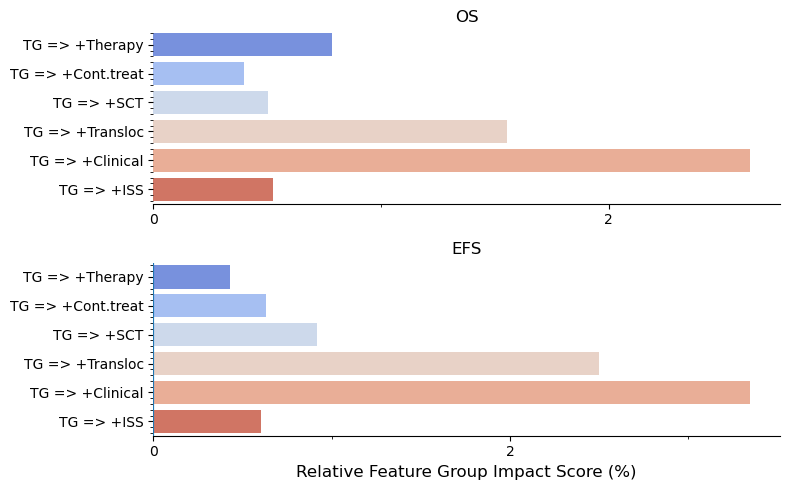

In [69]:
df_score_os = relative_importance(df_sub_c_ind_vals_os_atxyrs, order='backward')
df_score_efs = relative_importance(df_sub_c_ind_vals_efs_atxyrs, order='backward')

fig, (ax0, ax1) = plt.subplots(2, 1)
for (ax, df_score, titl) in [(ax0, df_score_os, 'OS'), (ax1, df_score_efs, 'EFS')]:
    plot_relative_imp(ax, df_score, titl)
plt.tight_layout()

In [70]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#f67b51','2. Leave-one-out cross validation: train on 1932 patients and test on 1 patient'))

</font><h1><strong><font color=#f67b51>2. Leave-one-out cross validation: train on 1932 patients and test on 1 patient</strong></h1>

In [71]:
# time_risk_days 
# multistates with probabilities
loocv_pred_multistate_at_xyr = pd.read_csv(base_dir + '/data_out/expt_1/preds_treatment/loo_neural_cox_non_prop_multistate_risks_at' + str(time_risk_days) + '.csv')

In [72]:
# raw data
df_dataset = pd.read_csv(base_dir + '/data_in/PMMM_matrix_12052022.txt', sep='\t');

df_dataset["age_group"] = np.select([(df_dataset.age < 65), (df_dataset.age >= 65) & (df_dataset.age < 75), 
                                     df_dataset.age >= 75, (df_dataset.age is not pd.isnull)], 
                                   ['less than 65 yrs', 'middle / between 65 to 74 yrs', 'more than 75yrs', 'unreported'])

In [73]:
# get time and event code
loocv_pred_multistate_at_xyr = pd.merge(loocv_pred_multistate_at_xyr, df_dataset, on='sample', how='inner')

In [74]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S15: Risk of OS and EFS in P1/P2'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S15: Risk of OS and EFS in P1/P2</strong></h1>

In [75]:
# Overall Survival
loo_atxyr = loocv_pred_multistate_at_xyr.copy()
loo_atxyr['event'] = np.select([
                        ((loo_atxyr['pfs_code'] == 1)|(loo_atxyr['os_code'] == 1)) & (loo_atxyr['phase'] == 'Phase1-only'),
                        ((loo_atxyr['pfs_code'] == 1)|(loo_atxyr['os_code'] == 1)) & (loo_atxyr['phase'] == 'Phase2'),
                        ((loo_atxyr['pfs_code'] == 0)|(loo_atxyr['os_code'] == 0)) 
                            & ((loo_atxyr['phase'] == 'Phase2') | (loo_atxyr['phase'] == 'Phase1-only')),
                              ], 
                    ['POD/Dec. in P1', 'POD/Dec. in P2', 'Alive in P1/P2'])


In [76]:
loo_atxyr['risk_os'] = 1 - (loo_atxyr['Alive in Induction'] + loo_atxyr['Alive in POD (induction)'] + loo_atxyr['Alive in Phase 2'] + loo_atxyr['Alive in POD'])
loo_atxyr['risk_efs'] = 1- (loo_atxyr['Alive in Induction'] + loo_atxyr['Alive in Phase 2'] + loo_atxyr['Death in Phase 2'])
loo_atxyr['risk_pfs'] = 1 - (loo_atxyr['Alive in Phase 2'])
print('Internal LOO')
print('OS risk min, max', loo_atxyr['risk_os'].min(), loo_atxyr['risk_os'].max())
print('EFS risk min, max', loo_atxyr['risk_efs'].min(), loo_atxyr['risk_efs'].max())
print('PFS risk min, max', loo_atxyr['risk_pfs'].min(), loo_atxyr['risk_pfs'].max())

Internal LOO
OS risk min, max 0.17344239330165923 0.5318141208497993
EFS risk min, max 0.4609123591383216 0.8246006326076609
PFS risk min, max 0.514208396648135 0.882042845421148


In [77]:
loo_atxyr.groupby(['event']).size()

event
Alive in P1/P2    729
POD/Dec. in P1    351
POD/Dec. in P2    853
dtype: int64

In [78]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (14, 12),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.constrained_layout.use' : True
         }
pylab.rcParams.update(params)

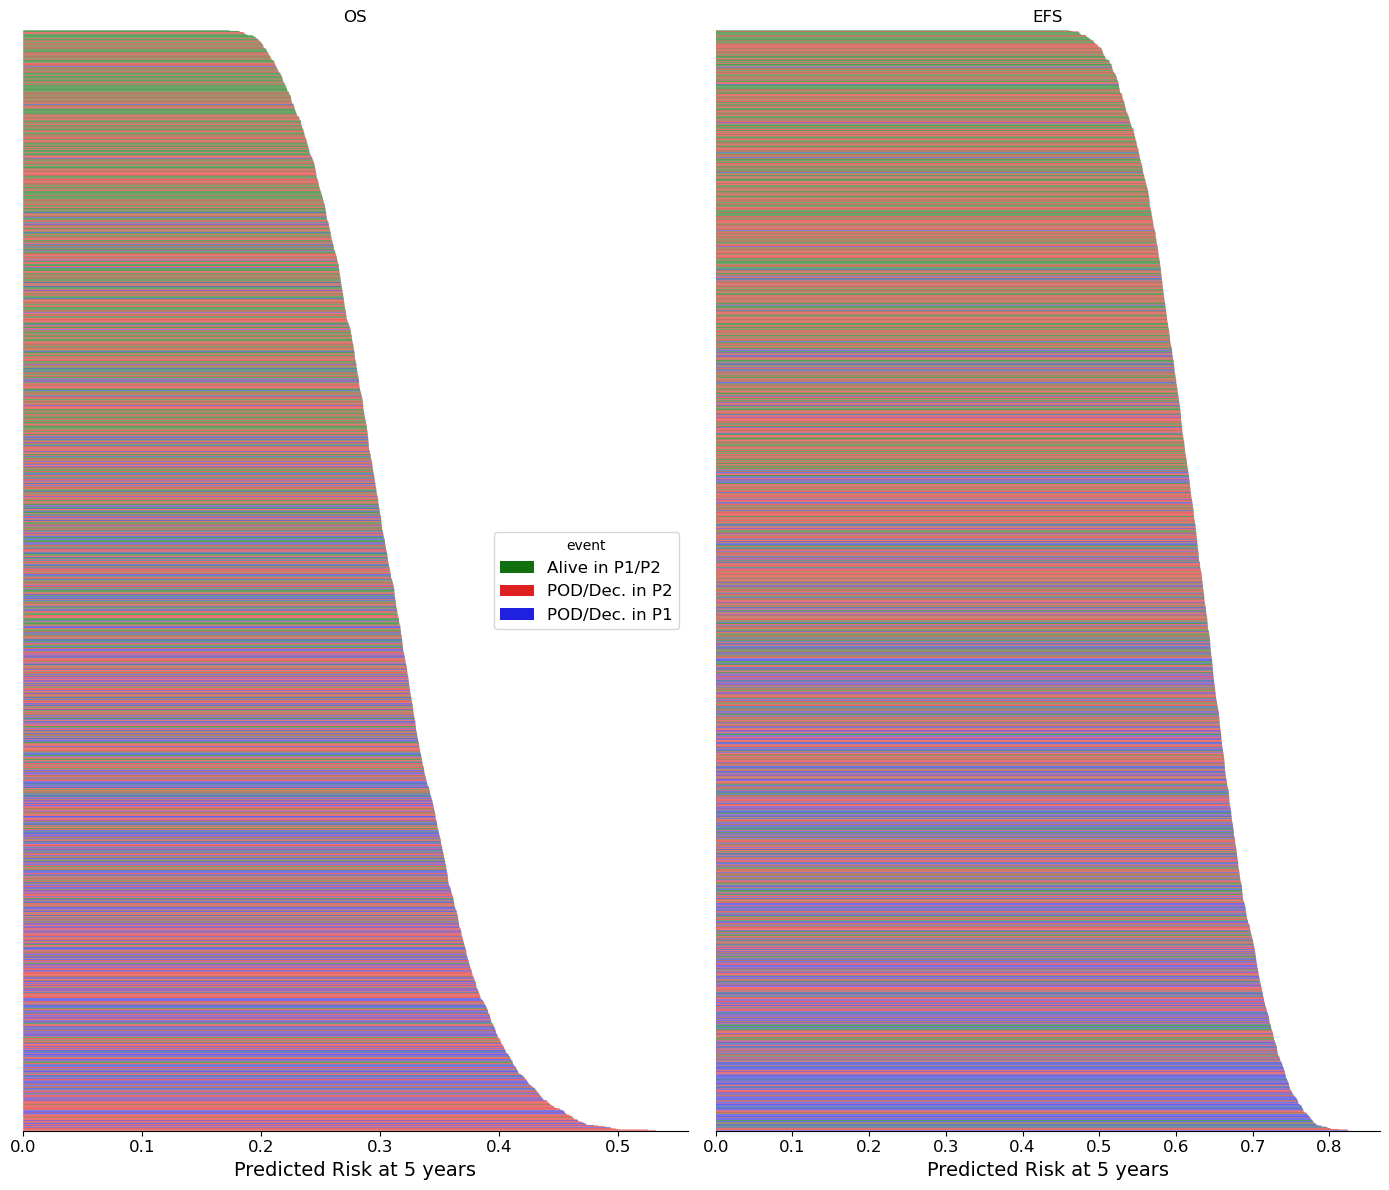

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(data=loo_atxyr.sort_values(by='risk_os', ascending=True), x="risk_os", y="sample", hue="event", dodge=False, snap=False, palette=['green', 'red', 'blue'], ax=ax1)
sns.barplot(data=loo_atxyr.sort_values(by='risk_efs', ascending=True), x="risk_efs", y="sample", hue="event", dodge=False, snap=False, palette=['green', 'red', 'blue'], ax=ax2)

for ax_, outcom_var in [(ax1, 'OS'), (ax2, 'EFS')]:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
    ax_.spines['left'].set_visible(False)
    ax_.set_xlabel('Predicted Risk at ' + str(round(time_risk_days/365)) + ' years', fontsize=14)
    ax_.set_yticks([])
    ax_.set_ylabel('')
    ax_.set_title(outcom_var)
    if ax_ == ax1:
        plt.legend([], [], frameon=False)
plt.tight_layout()

In [138]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S16: Effect of SCT (Internal - 1933 samples)'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S16: Effect of SCT (Internal - 1933 samples)</strong></h1>

In [140]:
params = {'legend.fontsize': 'medium',
          'figure.figsize': (12, 3),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.constrained_layout.use' : True
         }
pylab.rcParams.update(params)

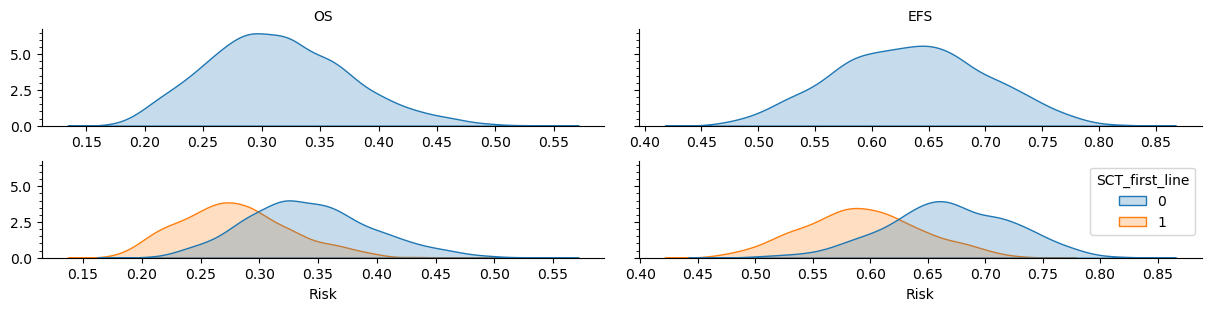

In [142]:
# kernel density estimation of Risk for OS, PFS

fig, axs = plt.subplots(2, 2, sharey=True)
ax0, ax1, ax2, ax3 = axs.flatten()

sns.kdeplot(data=loo_atxyr, x="risk_os", fill=True, ax=ax0)
sns.kdeplot(data=loo_atxyr, x='risk_os', hue='SCT_first_line', fill=True, ax=ax2, legend=False)
sns.kdeplot(data=loo_atxyr, x="risk_efs", fill=True, ax=ax1)
sns.kdeplot(data=loo_atxyr, x='risk_efs', hue='SCT_first_line', fill=True, ax=ax3, legend=True)
#sns.kdeplot(data=loo_atxyr, x="risk_pfs", fill=True, ax=ax2)
#sns.kdeplot(data=loo_atxyr, x='risk_pfs', hue='SCT_first_line', fill=True, ax=ax5, legend=True)

for (ax, titl_) in [(ax0, 'OS'), (ax1, 'EFS'), (ax2, ''), (ax3, '')]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.set_ylabel('')
    ax.set_title(titl_)
    if titl_ == '':
        ax.set_xlabel('Risk')
    else:
        ax.set_xlabel('')

In [83]:
feat_gp_combos = pd.read_csv(base_dir + '/data_out/expt_1/feat_matrix/' + 'main_keeper.csv')
feat_gp_combos_16 = feat_gp_combos[feat_gp_combos['group_id'] == 16]
top_gen_feats_IRMM = feat_gp_combos_16['feat_combo'].to_list()
top_gen_feats_IRMM = [feat for feats in top_gen_feats_IRMM for feat in feats.split()] + ['sample']

In [84]:
## OS
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#f67b51','3. Validation on external cohort'))

</font><h1><strong><font color=#f67b51>3. Validation on external cohort</strong></h1>

In [85]:
# External test set (Heidelberg)
# Groups: ISS, IRMM (with top genomic features)
group_test = '0~1~2~9~100'
var_name_c = 'C_index_harrell'

In [86]:
# os
outcome_type = os_hd;
df_os_1yr = pd.read_csv(targ_dir + outcome_type + "_365_group_" + group_test + ".csv")
df_os_2yr = pd.read_csv(targ_dir + outcome_type + "_730_group_" + group_test + ".csv")
df_os_3yr = pd.read_csv(targ_dir + outcome_type + "_1095_group_" + group_test + ".csv")
df_os_4yr = pd.read_csv(targ_dir + outcome_type + "_1460_group_" + group_test + ".csv")
df_os_5yr = pd.read_csv(targ_dir + outcome_type + "_1825_group_" + group_test + ".csv")

df_os_1yr['time_yr'] = 1; df_os_2yr['time_yr'] = 2; df_os_3yr['time_yr'] = 3; df_os_4yr['time_yr'] = 4; df_os_5yr['time_yr'] = 5

df_os_hd_time = df_os_1yr.append(df_os_2yr, ignore_index=True).append(df_os_3yr, ignore_index=True).append(df_os_4yr, ignore_index=True).append(df_os_5yr, ignore_index=True)


In [87]:
# efs
outcome_type = efs_hd; 
df_efs_1yr = pd.read_csv(targ_dir + outcome_type + "_365_group_" + group_test + ".csv")
df_efs_2yr = pd.read_csv(targ_dir + outcome_type + "_730_group_" + group_test + ".csv")
df_efs_3yr = pd.read_csv(targ_dir + outcome_type + "_1095_group_" + group_test + ".csv")
df_efs_4yr = pd.read_csv(targ_dir + outcome_type + "_1460_group_" + group_test + ".csv")
df_efs_5yr = pd.read_csv(targ_dir + outcome_type + "_1825_group_" + group_test + ".csv")

df_efs_1yr['time_yr'] = 1; df_efs_2yr['time_yr'] = 2; df_efs_3yr['time_yr'] = 3; df_efs_4yr['time_yr'] = 4; df_efs_5yr['time_yr'] = 5

df_efs_hd_time = df_efs_1yr.append(df_efs_2yr, ignore_index=True).append(df_efs_3yr, ignore_index=True).append(df_efs_4yr, ignore_index=True).append(df_efs_5yr, ignore_index=True)

In [88]:
df_os_hd_time = pd.merge(df_os_hd_time, rename_x_id_df, left_on='X_ID', right_on='old')[['ID', 'time_yr', var_name_c, 'Fold']]
df_os_hd_time = df_os_hd_time.dropna(subset=[var_name_c])

df_efs_hd_time = pd.merge(df_efs_hd_time, rename_x_id_df, left_on='X_ID', right_on='old')[['ID', 'time_yr',  var_name_c, 'Fold']]
df_efs_hd_time = df_efs_hd_time.dropna(subset=[var_name_c])

In [130]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 4),
         'axes.labelsize': 10,
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.constrained_layout.use' : True
         }
pylab.rcParams.update(params)

In [131]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S17: Concordance on external test set at times t'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S17: Concordance on external test set at times t</strong></h1>

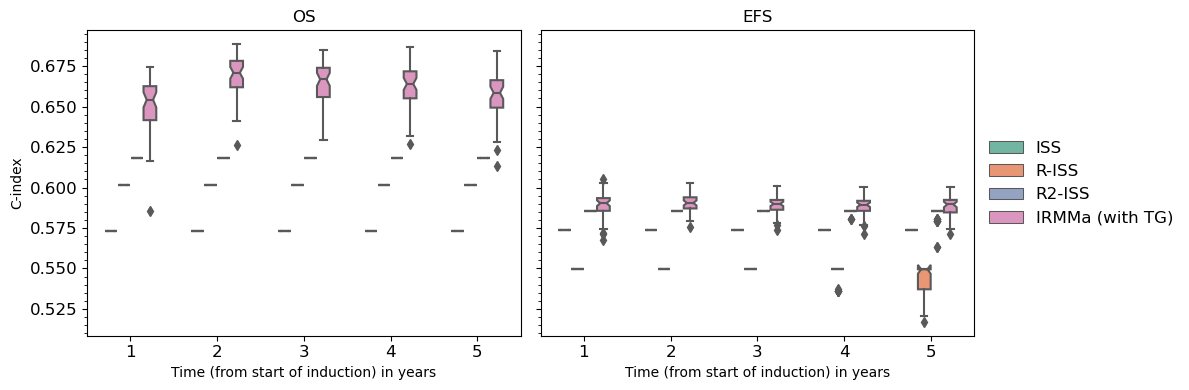

In [137]:
hue_order = ['ISS', 'R-ISS', 'R2-ISS', 'IRMMa (with TG)']

fig, axs = plt.subplots(1, 2, sharey=True)

ax_os, ax_efs = axs.flatten()

# os
sns.boxplot(x='time_yr', y=var_name_c, hue='ID', width=0.6, palette='Set2', data=df_os_hd_time, notch=True, hue_order=hue_order, ax=ax_os);
ax_os.set_xlabel('Time (from start of induction) in years') ; ax_os.set_ylabel('C-index') ; ax_os.get_legend().remove()
ax_os.set_title('OS')

# efs
sns.boxplot(x='time_yr', y=var_name_c, hue='ID', width=0.6, palette='Set2', data=df_efs_hd_time, notch=True, hue_order=hue_order, ax=ax_efs);
ax_efs.set_xlabel('Time (from start of induction) in years') ; ax_efs.set_ylabel('') ; ax_efs.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax_efs.set_title('EFS')
plt.tight_layout()



In [92]:
def clean_transform_raw_data(df):
    df_cp = df.copy()

    df_cp.drop(['time_SCT', 'duration', 'study', 'phase', 'DARA', 'ELO', 'SCT_line'], axis=1, inplace=True)

    df_feats = df_cp
    # map clinical vars
    map_gender = {'male': 0, 'female': 1, 'Male': 0, 'Female': 1}
    df_feats = df_feats.replace({'gender': map_gender})

    map_ecog = {'ecog<2': 0, 'ecog>=2': 1}
    df_feats = df_feats.replace({'ecog': map_ecog})

    map_iss = {'ISS1': 0, 'ISS2': 1, 'ISS3': 2, 'I': 0, 'II': 1, 'III': 2}
    df_feats = df_feats.replace({'ISS': map_iss})

    map_r_iss = {'R-ISS1': 0, 'R-ISS2': 1, 'R-ISS3': 2}
    df_feats = df_feats.replace({'R_ISS': map_r_iss})

    map_r2_iss = {'I': 0, 'II': 1, 'III': 2, 'IV':3}
    df_feats = df_feats.replace({'R2_ISS': map_r2_iss})

    df_feats["combo"] = np.select([df_feats.combo <= 1, df_feats.combo > 1], [0, 1])

    map_ldh = {'Low': 0, 'High': 1, 'Normal': 2}
    df_feats = df_feats.replace({'LDH_level': map_ldh})

    map_race = {'WHITE': 0, 'BLACK OR AFRICAN AMERICAN': 1, 'OTHER': 2}
    df_feats = df_feats.replace({'Race': map_race})

    df_feats["age_group"] = np.select([(df_feats.age < 65), (df_feats.age >= 65) & (df_feats.age < 75), df_feats.age >= 75], [0, 1, 2])

    df_feats = df_feats.set_index('sample')

    return df_feats


In [93]:
dir_all_states = base_dir + '/data_out/expt_1/kfold/state_probs/all_states/'

test_group_9_hd = dir_all_states + 'testGroup~hd~*'
list_files_test_gp_9_hd = glob.glob(test_group_9_hd)

In [94]:
## Heidelberg risk scores

## group + top genomics
risk_gp_9_hd = pd.DataFrame()
for filename in list_files_test_gp_9_hd:
    sample_id = filename.split('/')[-1].split('~')[2]
    single_df = pd.read_csv(filename, index_col=None, header=0)
    single_df = single_df[single_df['Time (Days)'] == time_risk_days]
    single_df['sample_id'] = sample_id
    risk_gp_9_hd = pd.concat([risk_gp_9_hd, single_df], ignore_index=True, axis=0)

risk_gp_9_hd['sample_id'] = risk_gp_9_hd['sample_id'].str.replace('\.', '-', regex=True)
risk_gp_9_hd_vals_folds = risk_gp_9_hd.copy()
risk_gp_9_hd_vals_folds['risk_os'] = 1 - (risk_gp_9_hd_vals_folds['Alive in Induction'] + risk_gp_9_hd_vals_folds['Alive in POD (induction)'] + risk_gp_9_hd_vals_folds['Alive in Phase 2'] + risk_gp_9_hd_vals_folds['Alive in POD'])
risk_gp_9_hd_vals_folds['risk_efs'] = 1- (risk_gp_9_hd_vals_folds['Alive in Induction'] + risk_gp_9_hd_vals_folds['Alive in Phase 2'] + risk_gp_9_hd_vals_folds['Death in Phase 2'])
risk_gp_9_hd_vals_folds['risk_pfs'] = 1 - risk_gp_9_hd_vals_folds['Alive in Phase 2']

In [95]:
risk_gp_9_hd = risk_gp_9_hd_vals_folds.groupby('sample_id').mean().reset_index()

In [96]:
# transformed HD
df_dataset_hd = pd.read_csv(base_dir + '/data_in/heidelberg_matrix.txt', sep='\t');
df_feats_transf_hd = clean_transform_raw_data(df_dataset_hd)
risk_gp_9_hd_cp = risk_gp_9_hd.copy()
df_feats_transf_hd['Event (POD or Dec)'] = np.select([
                            (df_feats_transf_hd['pfs_code'] == 0) & (df_feats_transf_hd['os_code'] == 0), 
                            (df_feats_transf_hd['pfs_code'] == 0) & (df_feats_transf_hd['os_code'] == 1),
                            (df_feats_transf_hd['pfs_code'] == 1) & (df_feats_transf_hd['os_code'] == 0),
                            (df_feats_transf_hd['pfs_code'] == 1) & (df_feats_transf_hd['os_code'] == 1)
                            ], ['No event', 'Dec.', 'POD', 'POD & Dec.'])

df_feats_transf_hd_cp = df_feats_transf_hd.copy()

hd_df_risks = pd.merge(risk_gp_9_hd_cp, df_feats_transf_hd_cp[['pfs_code', 'os_code', 'Event (POD or Dec)', 'age_group', 'age']], 
         left_on='sample_id', right_index= True, how='inner')

hd_df_risks_cp = hd_df_risks.copy()
hd_df_risks_cp['age_group'] = np.select([(hd_df_risks_cp['age_group']==0), 
                                         (hd_df_risks_cp['age_group']==1), 
                                         (hd_df_risks_cp['age_group']==2)], ['less than 65', '65 to 75', '>75'])

In [97]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#f67b51','4. Risk comparisons between 1933 samples (CV) and Heidelberg (HD) cohort'))

</font><h1><strong><font color=#f67b51>4. Risk comparisons between 1933 samples (CV) and Heidelberg (HD) cohort</strong></h1>

In [98]:
dir_all_states = base_dir + '/data_out/expt_1/kfold/state_probs/all_states/'

group_9_internal = dir_all_states + 'group~9~*'
list_files_gp_9_internal = glob.glob(group_9_internal)

In [99]:
len(list_files_gp_9_internal), len(list_files_test_gp_9_hd)

(19330, 12800)

In [100]:
## CV

## group + top genomics
risk_gp_9_internal = pd.DataFrame()
for filename in list_files_gp_9_internal:
    sample_id = filename.split('/')[-1].split('~')[3]
    single_df = pd.read_csv(filename, index_col=None, header=0)
    single_df = single_df[single_df['Time (Days)'] == time_risk_days]
    single_df['sample_id'] = sample_id
    risk_gp_9_internal = pd.concat([risk_gp_9_internal, single_df], ignore_index=True, axis=0)

risk_gp_9_internal['sample_id'] = risk_gp_9_internal['sample_id'].str.replace('\.', '-', regex=True)

risk_gp_9_internal_vals_folds = risk_gp_9_internal.copy()
risk_gp_9_internal_vals_folds['risk_os'] = 1 - (risk_gp_9_internal_vals_folds['Alive in Induction'] + risk_gp_9_internal_vals_folds['Alive in POD (induction)'] + risk_gp_9_internal_vals_folds['Alive in Phase 2'] + risk_gp_9_internal_vals_folds['Alive in POD'])
risk_gp_9_internal_vals_folds['risk_efs'] = 1- (risk_gp_9_internal_vals_folds['Alive in Induction'] + risk_gp_9_internal_vals_folds['Alive in Phase 2'] + risk_gp_9_internal_vals_folds['Death in Phase 2'])
risk_gp_9_internal_vals_folds['risk_pfs'] = 1 - risk_gp_9_internal_vals_folds['Alive in Phase 2']

In [101]:
risk_gp_9_internal = risk_gp_9_internal_vals_folds.groupby('sample_id').mean().reset_index()

In [102]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S18: Risk density between leave-one-out (LOOCV) and mean 50-fold CV'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S18: Risk density between leave-one-out (LOOCV) and mean 50-fold CV</strong></h1>

In [103]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 2),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.constrained_layout.use' : True
         }
pylab.rcParams.update(params)

Text(0, 0.5, '')

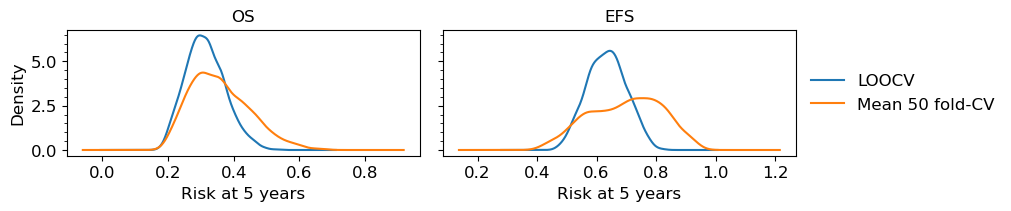

In [104]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
loo_atxyr['risk_os'].plot.kde(ax=ax1) ; 
risk_gp_9_internal['risk_os'].plot.kde(ax=ax1)
ax1.set_xlabel('Risk at ' + str(round(time_risk_days/365)) + ' years') ; ax1.set_title('OS')

loo_atxyr['risk_efs'].plot.kde(ax=ax2)
risk_gp_9_internal['risk_efs'].plot.kde(ax=ax2)
ax2.legend(labels=['LOOCV', 'Mean 50 fold-CV'], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) ; 
ax2.set_xlabel('Risk at ' + str(round(time_risk_days/365)) + ' years') ; ax2.set_title('EFS') ; ax2.set_ylabel('')

In [105]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.constrained_layout.use' : True
         }
pylab.rcParams.update(params)

In [106]:
# get time and event code
risk_gp_9_internal_cp = pd.merge(risk_gp_9_internal, 
                    df_dataset, left_on='sample_id', right_on='sample', how='inner')
risk_gp_9_internal_cp['vrd'] = np.where((risk_gp_9_internal_cp['BORT'] == 1) & (risk_gp_9_internal_cp['LEN'] == 1), 1, 0)

In [107]:
# get time and event code
risk_gp_9_hd_cp_ = pd.merge(risk_gp_9_hd, 
                    df_dataset_hd[['sample', 'pfs_time', 'pfs_code', 'os_time', 'os_code', 'phase', 
            'SCT_first_line', 'BORT', 'LEN', 'APOBEC']], left_on='sample_id', right_on='sample', how='inner')
risk_gp_9_hd_cp_['vrd'] = np.where((risk_gp_9_hd_cp_['BORT'] == 1) & (risk_gp_9_hd_cp_['LEN'] == 1), 1, 0)
loo_atxyr['vrd'] = np.where((loo_atxyr['BORT'] == 1) & (loo_atxyr['LEN'] == 1), 1, 0)

In [108]:
# transformed CV

df_feats_transf_internal = clean_transform_raw_data(df_dataset)
df_feats_transf_internal_cp = df_feats_transf_internal.copy()

risk_gp_9_internal.shape, risk_gp_9_hd.shape, df_feats_transf_internal.shape

((1933, 12), (256, 12), (1933, 158))

In [109]:
gp_9_feats_IRMMa = feat_gp_combos[feat_gp_combos['group_id'] == 9]['feat_combo'].tolist()
gp_9_feats_IRMMa = list(set([feat for feats in gp_9_feats_IRMMa for feat in feats.split()]) - set(['Race']))

In [110]:
def data_normalize(x_array, normaliz_type):
    """
    :param normaliz_type: data normalize / scalar technique
    :return: preprocessed numpy arrays x,y to feed into ML
    """

    if normaliz_type == 'normalizer':
        scaler = preprocess.Normalizer().fit(x_array)

    # Approach 2 Min-Max
    if normaliz_type == 'min_max':
        # print('Normalization using min-max')
        scaler = preprocess.MinMaxScaler(feature_range=(0, 1))

    if normaliz_type == 'max_abs':
        # print('Max abs scale')
        scaler = preprocess.MaxAbsScaler()

    if normaliz_type == 'std_scaler':
        # print('Standard scaler')
        scaler = preprocess.StandardScaler()

    if normaliz_type == 'power_transformer':
        # print('Power transformer')
        scaler = preprocess.power_transform(method='yeo-johnson')

    if normaliz_type is None:
        # print('No normalization performed')
        return x_array, None

    if x_array.shape[1] != 1:
        x_norm = scaler.fit_transform(x_array)
    else:
        x_norm = scaler.fit_transform(x_array.reshape(-1, 1))
    return x_norm, scaler

def imputer_knn(df):
    x_array = df.values
    x_array, _ = data_normalize(x_array, 'min_max')
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    imputer.fit(x_array)
    x_imputed = imputer.transform(x_array)
    # print('Missing: %d' % sum(np.isnan(x_imputed).flatten()))
    return x_imputed, imputer

In [111]:
import time; import math

def nearest_sampl(query, df_hd, df_loo, df_raw_internal, feat_ids, imputer):
    start = time.time()
    #pfs_time = df_hd.loc[query]['pfs_time']
    #os_time = df_hd.loc[query]['os_time']
    #pfs_code = df_hd.loc[query]['pfs_code']
    #os_code = df_hd.loc[query]['os_code']

    query_feat_vals = df_hd.loc[query][feat_ids]
    # impute
    test_x_hd = imputer.transform(query_feat_vals[set(feat_ids)-set('Race')].to_numpy().reshape(1, -1))
    query_feat_vals = pd.DataFrame(data=test_x_hd)
    query_feat_vals.columns = list(set(feat_ids)-set('Race'))
    query_feat_vals = query_feat_vals.squeeze(axis=0)

    # build therapy tree
    treats = ['chemo', 'KAR', 'LEN', 'BORT', 'THAL', 'SCT_first_line', 'continuos_treat']
    train_x_therapy, _ = imputer_knn(df_raw_internal[treats])
    query_therapy_vals = query_feat_vals[treats]
    tree_obj_therapy = KDTree(train_x_therapy)
    dist, indices = tree_obj_therapy.query(query_therapy_vals.to_numpy().reshape(1, -1), k=100)

    # filter dataset to rows from patients with same therapy (distance = 0)
    dist_ind = list(zip(dist[0],indices[0]))
    dist_ind = [(dis_, ind_) for (dis_, ind_) in dist_ind if dis_ == 0] 
    df_raw_internal = df_raw_internal.iloc[indices[0]]
    df_raw_internal = df_raw_internal.dropna()
    
    # tree with iss, clini, gen tree to get similar patients
    train_x_iss_clin_gen, _ = imputer_knn(df_raw_internal[set(feat_ids)-set(treats)]) 
    tree_obj_iss_clin_gen = KDTree(train_x_iss_clin_gen)
    query_iss_clin_gen_vals = query_feat_vals[set(feat_ids)-set(treats)]

    if not any(pd.isna(query_iss_clin_gen_vals)):
        dist, indices = tree_obj_iss_clin_gen.query(query_iss_clin_gen_vals.to_numpy().reshape(1, -1), k=10)
        retriev_sample_ids = []
        for (dist, ind) in zip(dist[0], indices[0]):
            sample_id = df_raw_internal[set(feat_ids)-set(treats)].iloc[ind].name
            retriev_sample_ids.append(sample_id)

        risks_closest_neighbors = df_loo[df_loo['sample'].isin(retriev_sample_ids)][['age', 'risk_os', 'risk_efs']]
        end = time.time()
        #print('sample time', end - start)
        return retriev_sample_ids, risks_closest_neighbors['risk_os'].agg(['mean']).tolist()[0], risks_closest_neighbors['risk_efs'].agg(['mean']).tolist()[0]
    else:
        return [], 'na', 'na'

In [112]:
# imputer test
_, imp_ = imputer_knn(df_feats_transf_internal_cp[set(gp_9_feats_IRMMa)-set('Race')])

In [113]:
df_dat_vrd_hd = df_dataset_hd.copy()
df_dat_vrd_hd['vrd'] = np.where((df_dat_vrd_hd['BORT'] == 1) & (df_dat_vrd_hd['LEN'] == 1), 1, 0)
df_dat_vrd_hd = df_dat_vrd_hd[(df_dat_vrd_hd['age'] < 75) & (df_dat_vrd_hd['vrd'] == 1)]

print('hd pats with vrd less than 75', df_dat_vrd_hd.shape[0])

df_new_risks__ = pd.DataFrame()
for sample in df_dat_vrd_hd['sample'].tolist():
    retr_sampl_ids, retr_os_risk, retr_efs_risk = nearest_sampl(sample, df_feats_transf_hd, loo_atxyr, df_feats_transf_internal_cp[gp_9_feats_IRMMa], gp_9_feats_IRMMa, imp_)
    df_new_risks__ = df_new_risks__.append({'sample_id' : sample, 'retr_os_risk' : retr_os_risk, 'retr_efs_risk' : retr_efs_risk, 'retr_sampl_ids': retr_sampl_ids}, ignore_index=True)

hd pats with vrd less than 75 256


In [114]:
loo_hd_IRMMa_with_retr_risks = pd.merge(risk_gp_9_hd_cp_, df_new_risks__, on='sample_id', how='inner')

In [115]:
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.constrained_layout.use' : True
         }
pylab.rcParams.update(params)

In [116]:
Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S19: Knowledge bank'))

</font><h1><strong><font color=#cf2518>Supplementary Figure S19: Knowledge bank</strong></h1>

In [117]:
print('LOO HD # patients after similarity hashing', loo_hd_IRMMa_with_retr_risks.shape[0])

LOO HD # patients after similarity hashing 256


Text(0, 0.5, '')

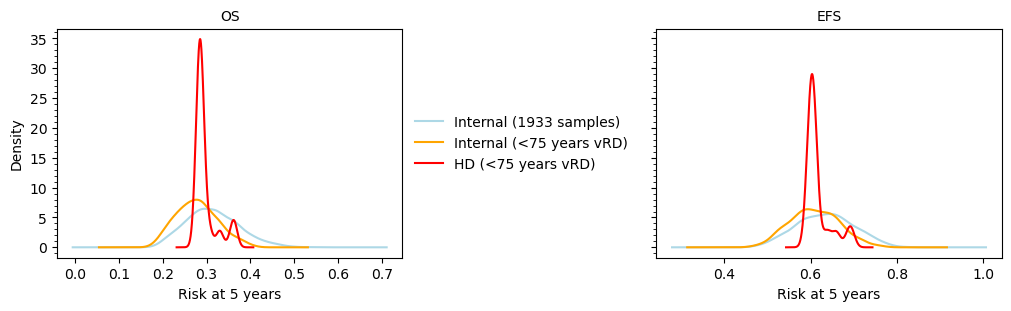

In [118]:
# density

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

#risk_gp_9_internal_cp[['sample_id', 'risk_os', 'risk_pfs']].to_csv(base_dir + '/data_out/expt_1/plots/density_5yrs_internal.csv', index=False)
#loo_hd_IRMMa_with_retr_risks[['sample_id', 'retr_os_risk', 'retr_pfs_risk']].to_csv(base_dir + '/data_out/expt_1/plots/density_5yrs_hd.csv', index=False)

loo_atxyr['risk_os'].plot.kde(ax=ax1, color='lightblue')
loo_atxyr['risk_os'][(loo_atxyr['vrd'] == 1) & (loo_atxyr['age'] < 75)].plot.kde(ax=ax1, color='orange') ; 
loo_hd_IRMMa_with_retr_risks['retr_os_risk'].plot.kde(ax=ax1, color='red') ;
ax1.set_xlabel('Risk at ' + str(round(time_risk_days/365)) + ' years') ; ax1.set_title('OS')

loo_atxyr['risk_efs'].plot.kde(ax=ax2, color='lightblue')
loo_atxyr['risk_efs'][(loo_atxyr['vrd'] == 1) & (loo_atxyr['age'] < 75)].plot.kde(ax=ax2, color='orange') ; 
loo_hd_IRMMa_with_retr_risks['retr_efs_risk'].plot.kde(ax=ax2, color='red') ;

ax1.legend(labels=['Internal (1933 samples)', 'Internal (<75 years vRD)', 'HD (<75 years vRD)'], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) ; 
ax2.set_xlabel('Risk at ' + str(round(time_risk_days/365)) + ' years') ; ax2.set_title('EFS') ; ax2.set_ylabel('')

Text(0, 0.5, '')

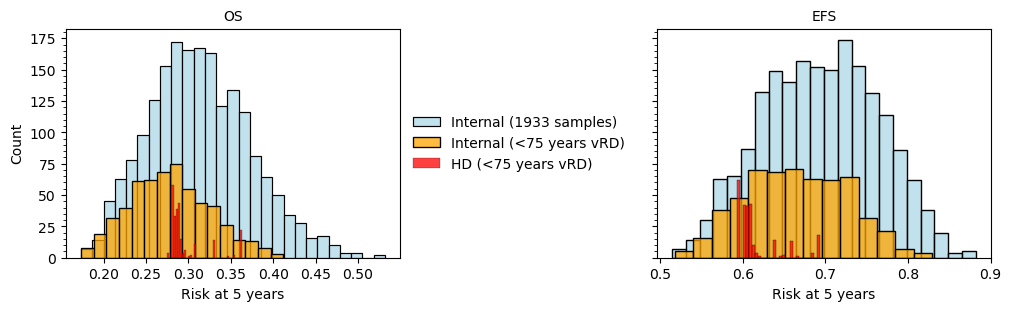

In [119]:
# hist
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

sns.histplot(data=loo_atxyr, x="risk_os", ax=ax1,  color='lightblue') #risk_gp_9_internal_cp
sns.histplot(data=loo_atxyr[(loo_atxyr['vrd'] == 1) & (loo_atxyr['age'] < 75)], x="risk_os", color='orange', ax=ax1)
sns.histplot(data=loo_hd_IRMMa_with_retr_risks, x="retr_os_risk", color='red', ax=ax1)
ax1.set_xlabel('Risk at ' + str(round(time_risk_days/365)) + ' years') ; ax1.set_title('OS')

sns.histplot(data=loo_atxyr, x="risk_pfs",  color='lightblue', ax=ax2)
sns.histplot(data=loo_atxyr[(loo_atxyr['vrd'] == 1) & (loo_atxyr['age'] < 75)], x="risk_pfs",  color='orange', ax=ax2)
sns.histplot(data=loo_hd_IRMMa_with_retr_risks, x="retr_efs_risk", color='red', ax=ax2)
ax2.set_xlabel('Risk at ' + str(round(time_risk_days/365)) + ' years') ; ax1.set_title('OS')

ax1.legend(labels=['Internal (1933 samples)', 'Internal (<75 years vRD)', 'HD (<75 years vRD)'], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) ; 
ax2.set_xlabel('Risk at ' + str(round(time_risk_days/365)) + ' years') ; ax2.set_title('EFS') ; ax2.set_ylabel('')

In [120]:
# params = {'legend.fontsize': 'medium',
#           'figure.figsize': (10, 3),
#          'axes.labelsize': 'medium',
#          'axes.titlesize':'medium',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium',
#          'figure.constrained_layout.use' : True
#          }
# pylab.rcParams.update(params)

In [121]:
# internal (all patients)
# fig, ax = plt.subplots()
# df_accum_internal_all = pd.read_csv(targ_dir + 'median_frac_of_patients_ext_val_False_at' + str(time_risk_days) + '.csv')
# df_accum_internal_all.columns = ['Non-POD in induction', 'POD in induction and alive',
#                   'Non-POD and alive', 'POD after induction and alive', 'POD in induction and death',
#                   'Non-POD and death', 'POD after induction and death']

# df_accum_internal_all['median_prob_surv_internal_all'] = df_accum_internal_all['Non-POD in induction'] + df_accum_internal_all['POD in induction and alive'] + df_accum_internal_all['Non-POD and alive'] + df_accum_internal_all['POD after induction and alive']
# df_accum_internal_all['median_prob_pfs_internal_all'] = df_accum_internal_all['Non-POD in induction'] + df_accum_internal_all['Non-POD and alive'] 
# df_accum_internal_all['median_prob_efs_internal_all'] = df_accum_internal_all['Non-POD in induction'] + df_accum_internal_all['Non-POD and alive'] + df_accum_internal_all['Non-POD and death']

# # mean
# df_accum_internal_all_mean = pd.read_csv(targ_dir + 'mean_frac_of_patients_ext_val_False_at' + str(time_risk_days) + '.csv')
# df_accum_internal_all_mean.columns = ['Non-POD in induction', 'POD in induction and alive',
#                   'Non-POD and alive', 'POD after induction and alive', 'POD in induction and death',
#                   'Non-POD and death', 'POD after induction and death']

# df_accum_internal_all_mean['mean_prob_surv_internal_all'] =  df_accum_internal_all_mean['Non-POD in induction'] + df_accum_internal_all_mean['POD in induction and alive'] + df_accum_internal_all_mean['Non-POD and alive'] + df_accum_internal_all_mean['POD after induction and alive']
# df_accum_internal_all_mean['mean_prob_pfs_internal_all'] = df_accum_internal_all_mean['Non-POD in induction'] + df_accum_internal_all_mean['Non-POD and alive'] 
# df_accum_internal_all_mean['mean_prob_efs_internal_all'] = df_accum_internal_all_mean['Non-POD in induction'] + df_accum_internal_all_mean['Non-POD and alive'] + df_accum_internal_all_mean['Non-POD and death']
  
# df_accum_internal_all[['median_prob_surv_internal_all', 'median_prob_pfs_internal_all', 'median_prob_efs_internal_all']].plot.kde(color=['red', 'green', 'blue'], ax=ax)
# df_accum_internal_all_mean[['mean_prob_surv_internal_all', 'mean_prob_pfs_internal_all', 'mean_prob_efs_internal_all']].plot.kde(color=['red', 'green', 'blue'], ax=ax, linestyle='--')
# ax.set_xlabel('Probabilities')

#df_accum_internal_all.to_csv(base_dir + '/data_out/expt_1/plots/median_prob_curves_internal_all.csv', index=False)

In [122]:
# # internal (vrd < 75 years)
# df_dat_vrd_internal = df_dataset.copy()
# df_dat_vrd_internal['vrd'] = np.where((df_dat_vrd_internal['BORT'] == 1) & (df_dat_vrd_internal['LEN'] == 1), 1, 0)
# sampl_ids_internal_vrd = df_dat_vrd_internal[(df_dat_vrd_internal['age'] < 75) & (df_dat_vrd_internal['vrd'] == 1)]['sample'].tolist()

# print('internal pats with vrd < 75 years', len(sampl_ids_internal_vrd))

# output_files = glob.glob(base_dir + '/data_out/expt_1/loo/state_probs/*orig*.csv')
# output_files_ids = [item.split('/')[-1].split('~')[0] for item in output_files]
# subset_files = []
# print(len(sampl_ids_internal_vrd), len(output_files), len(output_files_ids))
# for ind, sampl_id in enumerate(sampl_ids_internal_vrd):
#     if sampl_id in output_files_ids:
#         ind_sampl = output_files_ids.index(sampl_id)
#         subset_files.append(output_files[ind_sampl])

# print('files less than 75', len(subset_files))

# data_list = []
# for ind, filename in enumerate(subset_files):
#     single_df = pd.read_csv(filename, index_col=None, header=0)
#     data_list.append(single_df.head(time_risk_days))
# df = pd.concat(data_list, axis=1)
# df = df.drop(['sample', 'Time (Days)'], axis=1)

In [123]:
# ##
# fig , ax = plt.subplots()
# df_accum_internal_vrd = pd.DataFrame()
# df_accum_internal_vrd_mean = pd.DataFrame()

# for ind, group in enumerate(df.columns.unique()):
#     spec_cols = [col for col in df.columns if group == col]
#     df_spec = df[spec_cols]
#     # median
#     df_agg = df_spec.median(axis=1).abs()    
#     df_agg = df_agg.reset_index()
#     df_agg = df_agg.drop('index', axis=1)
#     df_agg.columns = [group]
#     # mean
#     df_agg_mean = df_spec.mean(axis=1).abs()    
#     df_agg_mean = df_agg_mean.reset_index()
#     df_agg_mean = df_agg_mean.drop('index', axis=1)
#     df_agg_mean.columns = [group]
    
#     df_accum_internal_vrd_mean = pd.concat((df_accum_internal_vrd_mean, df_agg_mean), axis=1)
#     df_accum_internal_vrd = pd.concat((df_accum_internal_vrd, df_agg), axis=1)

# df_accum_internal_vrd.columns = ['Non-POD in induction', 'POD in induction and alive',
#                   'Non-POD and alive', 'POD after induction and alive', 'POD in induction and death',
#                   'Non-POD and death', 'POD after induction and death']
# df_accum_internal_vrd['median_prob_surv_internal_vrd_less_75'] = df_accum_internal_vrd['Non-POD in induction'] + df_accum_internal_vrd['POD in induction and alive'] + df_accum_internal_vrd['Non-POD and alive'] + df_accum_internal_vrd['POD after induction and alive']
# df_accum_internal_vrd['median_prob_pfs_internal_vrd_less_75'] = df_accum_internal_vrd['Non-POD in induction'] + df_accum_internal_vrd['Non-POD and alive'] 
# df_accum_internal_vrd['median_prob_efs_internal_vrd_less_75'] = df_accum_internal_vrd['Non-POD in induction'] + df_accum_internal_vrd['Non-POD and alive'] + df_accum_internal_vrd['Non-POD and death']

# # mean
# df_accum_internal_vrd_mean.columns = ['Non-POD in induction', 'POD in induction and alive',
#                   'Non-POD and alive', 'POD after induction and alive', 'POD in induction and death',
#                   'Non-POD and death', 'POD after induction and death']
# df_accum_internal_vrd_mean['mean_prob_surv_internal_vrd_less_75'] = df_accum_internal_vrd_mean['Non-POD in induction'] + df_accum_internal_vrd_mean['POD in induction and alive'] + df_accum_internal_vrd_mean['Non-POD and alive'] + df_accum_internal_vrd_mean['POD after induction and alive']
# df_accum_internal_vrd_mean['mean_prob_pfs_internal_vrd_less_75'] = df_accum_internal_vrd_mean['Non-POD in induction'] + df_accum_internal_vrd_mean['Non-POD and alive'] 
# df_accum_internal_vrd_mean['mean_prob_efs_internal_vrd_less_75'] = df_accum_internal_vrd_mean['Non-POD in induction'] + df_accum_internal_vrd_mean['Non-POD and alive'] + df_accum_internal_vrd_mean['Non-POD and death']

# # print(df_accum_internal_vrd[['median_prob_surv_internal_vrd_less_75', 'median_prob_pfs_internal_vrd_less_75', 'median_prob_efs_internal_vrd_less_75']])
# df_accum_internal_vrd[['median_prob_surv_internal_vrd_less_75', 'median_prob_pfs_internal_vrd_less_75', 'median_prob_efs_internal_vrd_less_75']].plot.kde(color=['red', 'green', 'blue'], ax=ax)
# df_accum_internal_vrd_mean[['mean_prob_surv_internal_vrd_less_75', 'mean_prob_pfs_internal_vrd_less_75', 'mean_prob_efs_internal_vrd_less_75']].plot.kde(color=['red', 'green', 'blue'], ax=ax, linestyle='--')
# ax.set_xlabel('Probabilities')
# #df_accum_internal_vrd.to_csv(base_dir + '/data_out/expt_1/plots/median_prob_curves_internal_vrd_75.csv', index=False)

In [124]:
# # hd6 using our knowledge bank model

# list_retr_sampl_ids = df_new_risks__['retr_sampl_ids'].tolist()
# flat_list_retr_sampl_ids = [item for sublist in list_retr_sampl_ids for item in sublist]
# flat_list_retr_sampl_ids = list(set(flat_list_retr_sampl_ids))

# output_files = glob.glob(base_dir + '/data_out/expt_1/loo/state_probs/*orig*.csv')
# output_files_ids = [item.split('/')[-1].split('~')[0] for item in output_files]
# subset_files = []

# for ind, sampl_id in enumerate(flat_list_retr_sampl_ids):
#     if sampl_id in output_files_ids:
#         ind_sampl = output_files_ids.index(sampl_id)
#         subset_files.append(output_files[ind_sampl])

# pd.DataFrame(subset_files).to_csv(base_dir + '/data_out/expt_1/plots/knowled_bank_samples.csv', index=False)

# data_list = []
# for ind, filename in enumerate(subset_files):
#     single_df = pd.read_csv(filename, index_col=None, header=0)
#     data_list.append(single_df.head(time_risk_days))
# df = pd.concat(data_list, axis=1)
# df = df.drop(['sample', 'Time (Days)'], axis=1)

# ##
# df_accum_hd = pd.DataFrame()
# for ind, group in enumerate(df.columns.unique()):
#     spec_cols = [col for col in df.columns if group == col]
#     df_spec = df[spec_cols]
#     df_mean = df_spec.median(axis=1).abs()
#     df_mean = df_mean.reset_index()
#     df_mean = df_mean.drop('index', axis=1)
#     df_mean.columns = [group]
#     df_accum_hd = pd.concat((df_accum_hd, df_mean), axis=1)

# df_accum_hd.columns = ['Non-POD in induction', 'POD in induction and alive',
#                   'Non-POD and alive', 'POD after induction and alive', 'POD in induction and death',
#                   'Non-POD and death', 'POD after induction and death']

# df_accum_hd['prob_surv_hd'] = df_accum_hd['Non-POD in induction'] + df_accum_hd['POD in induction and alive'] + df_accum_hd['Non-POD and alive'] + df_accum_hd['POD after induction and alive']
# df_accum_hd['prob_pfs_hd'] = df_accum_hd['Non-POD in induction'] + df_accum_hd['Non-POD and alive']
# df_accum_hd['prob_efs_hd'] = df_accum_hd['Non-POD in induction'] + df_accum_hd['Non-POD and alive'] + df_accum_hd['Non-POD and death']

# #df_accum_hd.to_csv(base_dir + '/data_out/expt_1/plots/median_prob_curves_hd_vrd_75.csv', index=False)

In [125]:
# from functools import reduce
# data_frames = [df_accum_internal_all[['prob_surv_internal_all','prob_efs_internal_all','prob_pfs_internal_all']], df_accum_internal_vrd[['prob_surv_internal_vrd_less_75','prob_efs_internal_vrd_less_75','prob_pfs_internal_vrd_less_75']], df_accum_hd[['prob_surv_hd','prob_efs_hd','prob_pfs_hd']]]
# df_accum_merge = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
#                                               left_index=True, right_index=True, 
#                                               how='inner'), data_frames)
# df_accum_merge.index = df_accum_merge.index/365

In [126]:
# params = {'legend.fontsize': 'medium',
#           'figure.figsize': (8, 4),
#          'axes.labelsize': 'medium',
#          'axes.titlesize':'medium',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium',
#          'figure.constrained_layout.use' : True
#          }
# pylab.rcParams.update(params)

In [127]:
#Markdown('</font><h1><strong><font color={}>{}</strong></h1>'.format('#cf2518','Supplementary Figure S: Model predictions in time'))

In [128]:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# df_accum_merge.reset_index().plot.line(x='index', y='prob_surv_internal_all', ax=ax1) # all pats internal
# df_accum_merge.reset_index().plot.line(x='index', y='prob_surv_internal_vrd_less_75', ax=ax1) # vrd < 75 internal
# df_accum_merge.reset_index().plot.line(x='index', y='prob_surv_hd', ax=ax1) # all pats HD
# ax1.set_title('OS')
# ax1.set_xlabel('Time (in years) from start of induction')

# df_accum_merge.reset_index().plot.line(x='index', y='prob_efs_internal_all', ax=ax2) # all pats internal
# df_accum_merge.reset_index().plot.line(x='index', y='prob_efs_internal_vrd_less_75', ax=ax2) # vrd < 75 internal
# df_accum_merge.reset_index().plot.line(x='index', y='prob_efs_hd', ax=ax2) # all pats HD
# ax2.set_title('EFS')
# ax2.set_xlabel('Time (in years) from start of induction')

In [129]:
##